# Data Analysis of Siemens Web shop Revenues

## Task

You are requested to perform a data analysis and forecasting problem using the dataset provided.

The dataset is sourced from our foreign exchange and commodity risk team's foreign exchange (FX)
portfolio. 

Your task is to conduct an analysis of this data, while also generating insights for the future.



## Preprocess the data

### Apply setting 

In [1]:
# load libraries
import numpy as np
import pandas as pd
import sys, time, os
from datetime import date
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# determine the path to the source folder
pth_to_src = 'C:/DEV/portfolio/src/'

# get date of today:
# Reason: Create outputfolder with current date to store plots and trained model if wanted.
today = date.today().strftime('%Y%m%d')

# input folder:
input_folder = pth_to_src + 'input/'

# output folder:
output_folder = pth_to_src + 'output/' + today + '/' # with date of today. This way a daily history of results can be automatically stored.
output_folder_plots = output_folder+'plots/'  
output_folder_model = output_folder+'model/'

# create output_folder if not existant:
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_folder_plots, exist_ok=True)
os.makedirs(output_folder_model, exist_ok=True)
# load utility functions
sys.path.append(pth_to_src+'/utils/')
from utility import *
# reload functions from utility
from importlib import reload
reload(sys.modules['utility'])

# set random seed for reproducibility
np.random.seed(888) 

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load, clean, prepare and check the data

In [2]:
# Read the dataframe:
# ignore the empty column Bonuses and the redundant column System.
metrics = ['ChangeRequestCosts', 'AdministrationCosts', 'OverheadCosts', 'Interests', 'Revenue'] 
df = pd.read_excel(pth_to_src+'input/fx_portfolio.xlsx', parse_dates=['Date'], usecols = ['CCY', 'Date'] +metrics ) 
# fill in the values for the merged row cells for column CCY:
df.CCY = pd.Series(df.CCY).fillna(method='ffill')


In [3]:
# add Profit and cumulative profit
df['Profit'] = df[['ChangeRequestCosts', 'AdministrationCosts',
       'OverheadCosts', 'Interests', 'Revenue']].sum(axis=1)

#set date and CCY as index
df = df.set_index([df.Date, df.CCY])

# add _Total_  as sum of the currencies:
df1 = df.groupby(level='Date').sum(numeric_only=True)
df1['CCY'] = '_Total_'
df1['Date'] = df1.index
df1 = df1.set_index([df1.index, df1.CCY])
# append total to df:
df = pd.concat([df, df1])
df = df.set_index([df.Date, df.CCY])

# calculate the cumulative profit:
df['CumulativeProfit']  = df['Profit'].groupby(level='CCY').cumsum()
metrics += ['Profit']

# add the year from :
df['year'] = df.Date.dt.year

# add the fiscal year from 10/10 until 09/30 of the next year:
# Reason: the data seems to be structured in this respective fiscal year.
df['fiscalYear'] = df.Date.dt.to_period('Q-SEP').astype(str).str.extract('(?P<year>\d+)')

df.head(4)

CCY       Date  ChangeRequestCosts  AdministrationCosts  \
Date       CCY                                                            
2019-10-01 EUR  EUR 2019-10-01                 0.0                  0.0   
2019-10-02 EUR  EUR 2019-10-02                 0.0                  0.0   
2019-10-03 EUR  EUR 2019-10-03                 0.0                  0.0   
2019-10-04 EUR  EUR 2019-10-04                 0.0                  0.0   

                OverheadCosts  Interests   Revenue    Profit  \
Date       CCY                                                 
2019-10-01 EUR        -479.45      89.00  16749.79  16359.34   
2019-10-02 EUR        -419.33      80.92  97028.32  96689.91   
2019-10-03 EUR        -446.22     105.12  20628.55  20287.45   
2019-10-04 EUR           0.00     125.52  17327.73  17453.25   

                CumulativeProfit  year fiscalYear  
Date       CCY                                     
2019-10-01 EUR          16359.34  2019       2020  
2019-10-02 EUR         113049.25  2019       2020  
2019-10-03 EUR         133336.70  2019       2020  
2019-10-04 EUR         150789.95  2019       2020

In [4]:
# Show the number of rows and columns of the dataframe:
df.shape

(3920, 11)

In [5]:
# replace the entries with missing values rows with zeros
# Reason: for some day there is no cashflow recorded. So the cash-flows are zero at these days. We may want to keep a data set with full records of daily observations within a week. Doing so can allow us to account for a seasonal trends later on.
print('Number of missing observations with missing data before filling in: %s'%sum(df[metrics].isna().any(axis=1)))
df = df.fillna(0)
print('Number of missing observations with missing data after  filling in: %s'%sum(df[metrics].isna().any(axis=1)))


Number of missing observations with missing data before filling in: 16
Number of missing observations with missing data after  filling in: 0


In [6]:
# Check the number of missing values of each column:
pd.DataFrame([df.isna().sum(),df.isna().mean()],index=['Number of missing values', 'Rate of missing values']).T

Number of missing values  Rate of missing values
CCY                                       0.0                     0.0
Date                                      0.0                     0.0
ChangeRequestCosts                        0.0                     0.0
AdministrationCosts                       0.0                     0.0
OverheadCosts                             0.0                     0.0
Interests                                 0.0                     0.0
Revenue                                   0.0                     0.0
Profit                                    0.0                     0.0
CumulativeProfit                          0.0                     0.0
year                                      0.0                     0.0
fiscalYear                                0.0                     0.0

In [7]:
# Show basic summary statistics of the data:
df.describe()

ChangeRequestCosts  AdministrationCosts  OverheadCosts     Interests  \
count         3920.000000          3920.000000    3920.000000   3920.000000   
mean         -1135.364653          -190.959653    -182.248291    793.951352   
std           5880.314972           943.247451     253.829884   3040.191015   
min         -56578.400000         -6098.970000   -1441.100000  -4144.080000   
25%              0.000000             0.000000    -307.087500     -0.520000   
50%              0.000000             0.000000     -41.795000     24.865000   
75%              0.000000             0.000000       0.000000    188.215000   
max              0.000000             0.000000       0.000000  37312.230000   

             Revenue         Profit  CumulativeProfit         year  
count    3920.000000    3920.000000      3.920000e+03  3920.000000  
mean    12622.722505   11908.101260      4.368011e+06  2020.746173  
std     26466.279294   26832.424068      6.568475e+06     0.924896  
min         0.000000  -48500.090000     -5.068346e+04  2019.000000  
25%        63.387500      24.775000      1.804121e+04  2020.000000  
50%       653.900000     766.225000      1.916453e+05  2021.000000  
75%     12296.157500   11242.890000      8.384901e+06  2021.000000  
max    207016.190000  204689.240000      2.333988e+07  2022.000000

In [8]:
# Show frequency table per CCY and year  in the data set:
year_freq =df.copy().drop(columns=['CCY']).groupby(['fiscalYear','CCY']).size() 
year_freq.columns =['Count']
year_freq

fiscalYear  CCY    
2020        CHF        262
            EUR        262
            GBP        262
            USD        262
            _Total_    262
2021        CHF        261
            EUR        261
            GBP        261
            USD        261
            _Total_    261
2022        CHF        261
            EUR        261
            GBP        261
            USD        261
            _Total_    261
dtype: int64

In [76]:
# Show key metrics per year and CCY:
metrics_per_year_CCY = df[['fiscalYear']+metrics].groupby(['fiscalYear','CCY']).sum()
pd.options.display.float_format =  '{:,.0f}'.format
metrics_per_year_CCY

TypeError: can only concatenate list (not "module") to list

In [10]:
# reset display settings
pd.reset_option('^display.', silent=True)

#### Plots per month

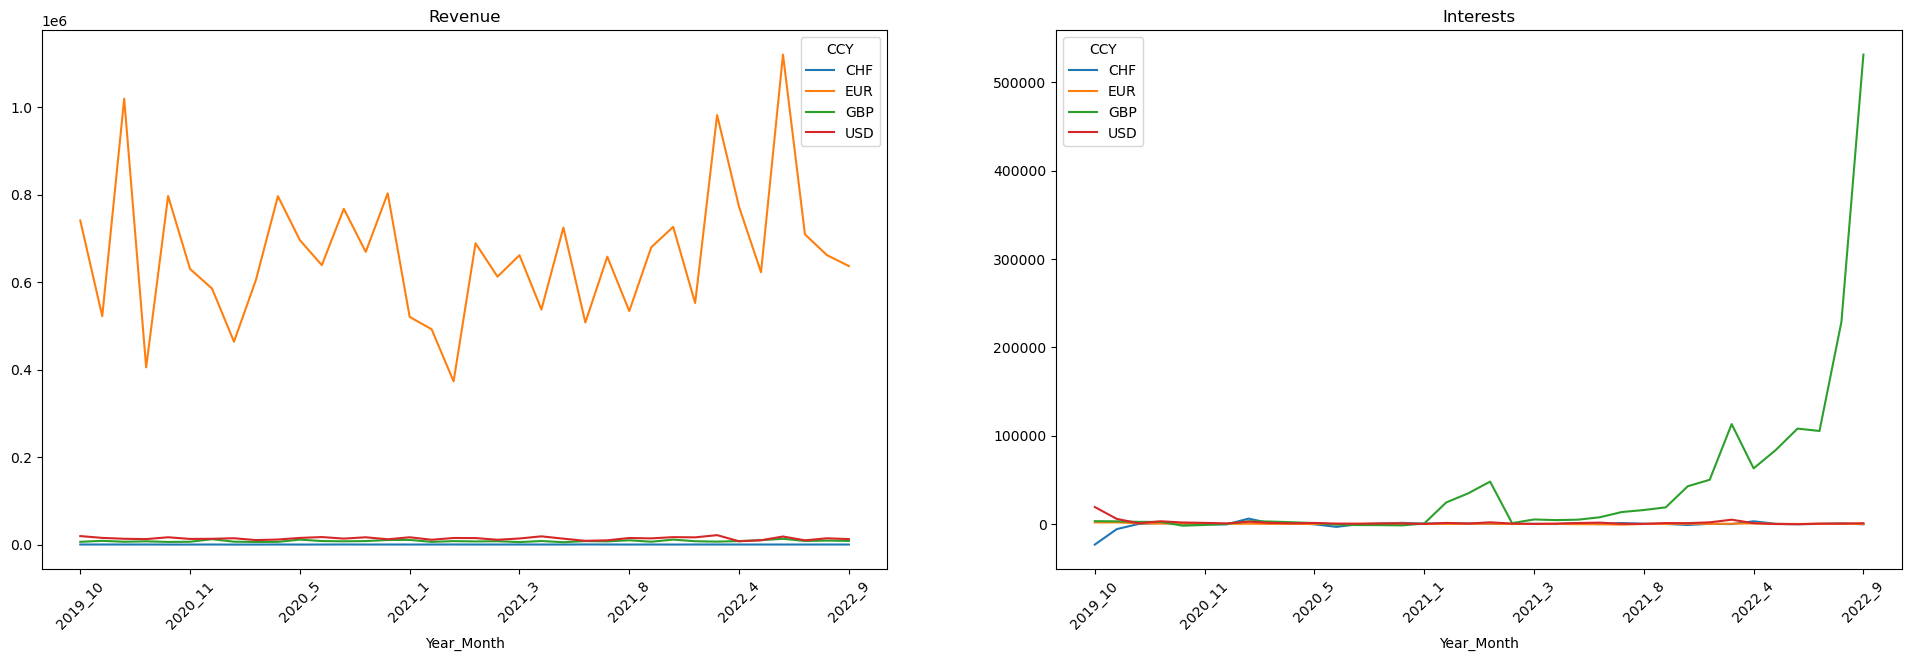

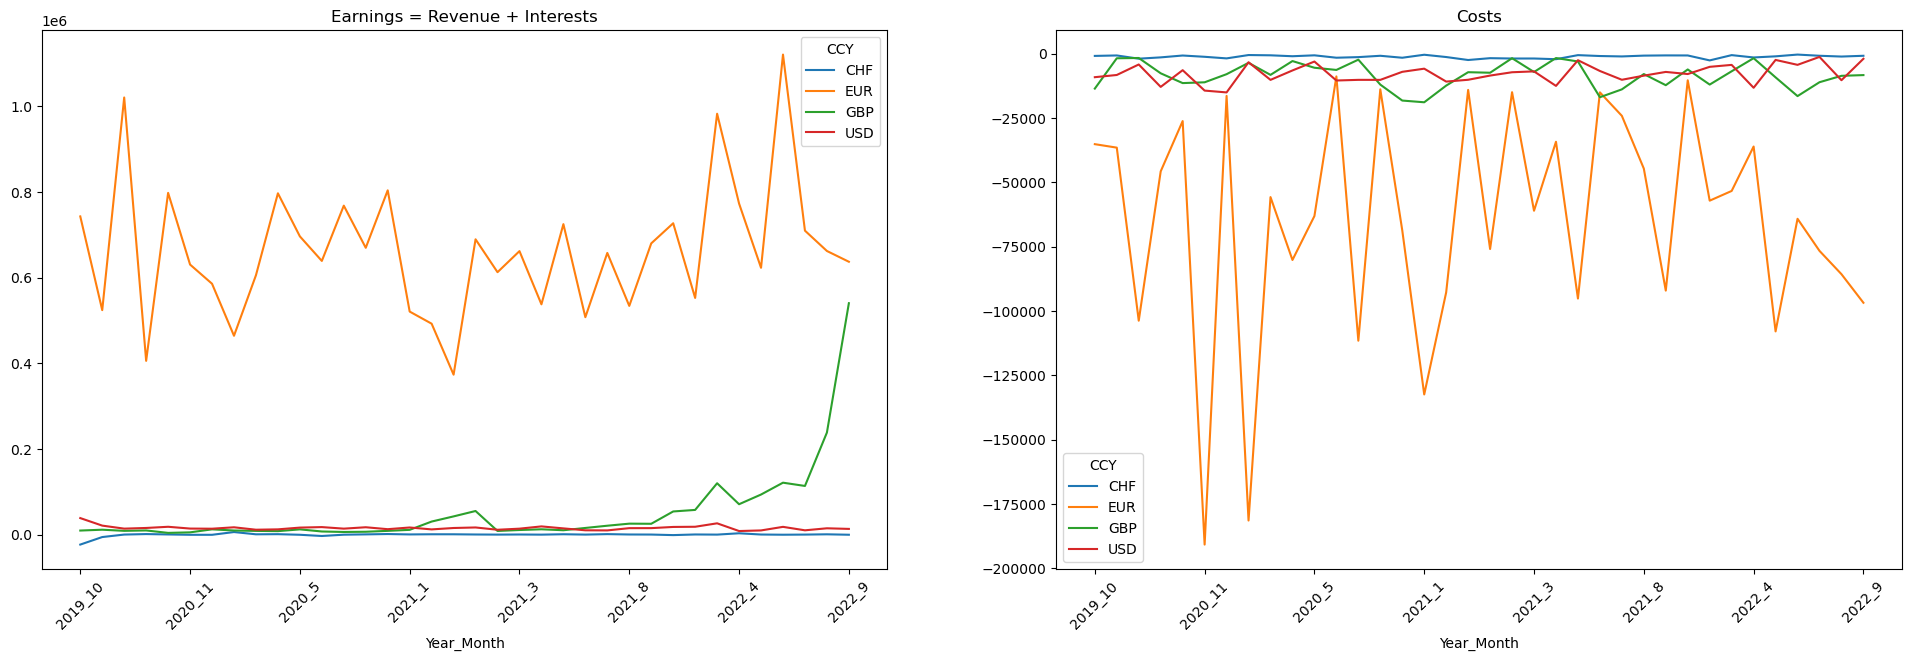

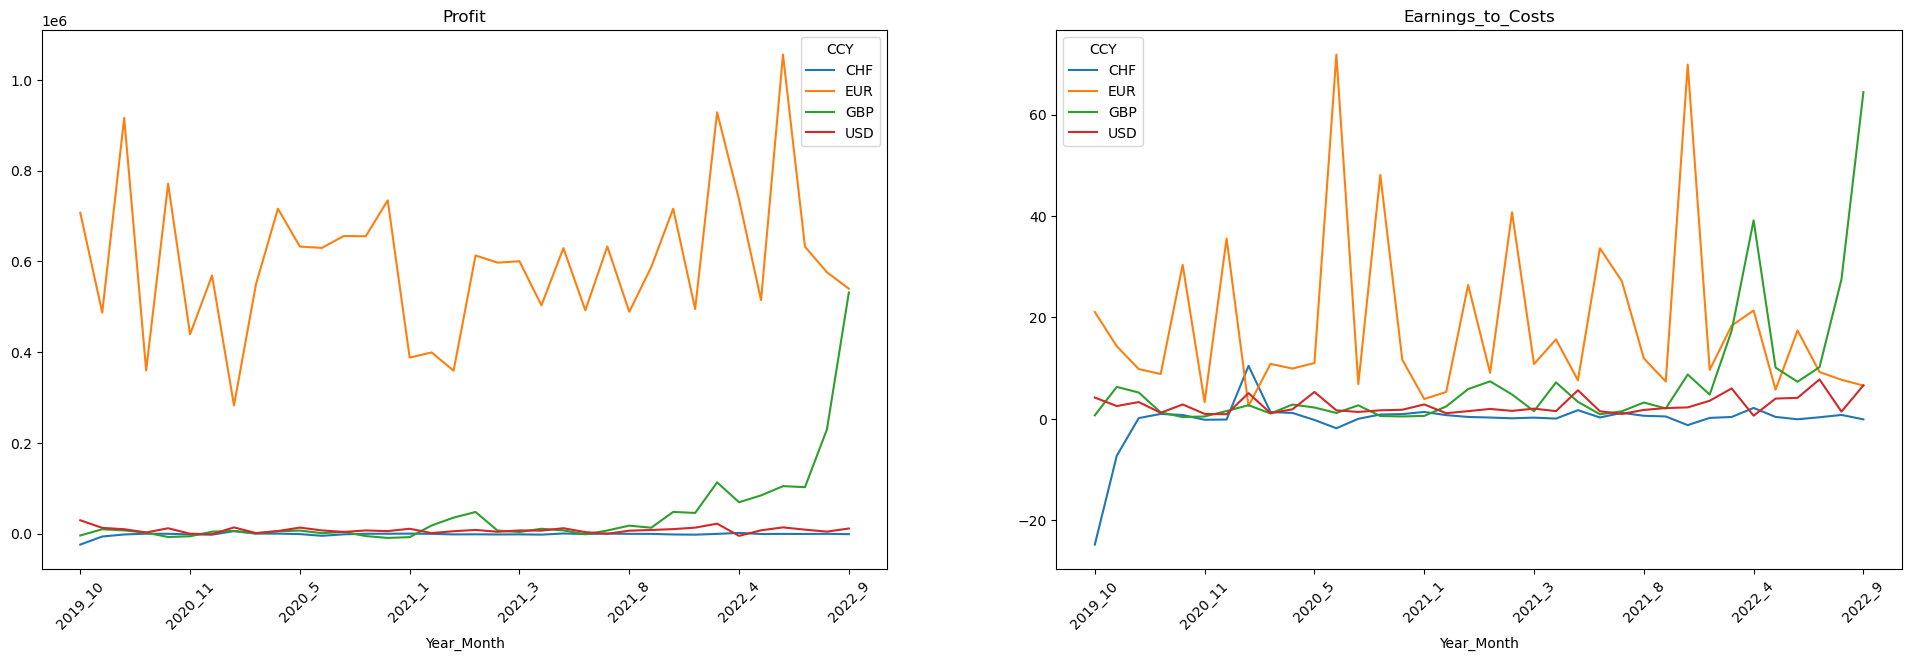

In [11]:
# plot descriptive graphs per month:
ratios_CCY = plot_descriptives_per_moth(df)

### Explorative analysis of the data

#### Average daily values per fiscal year

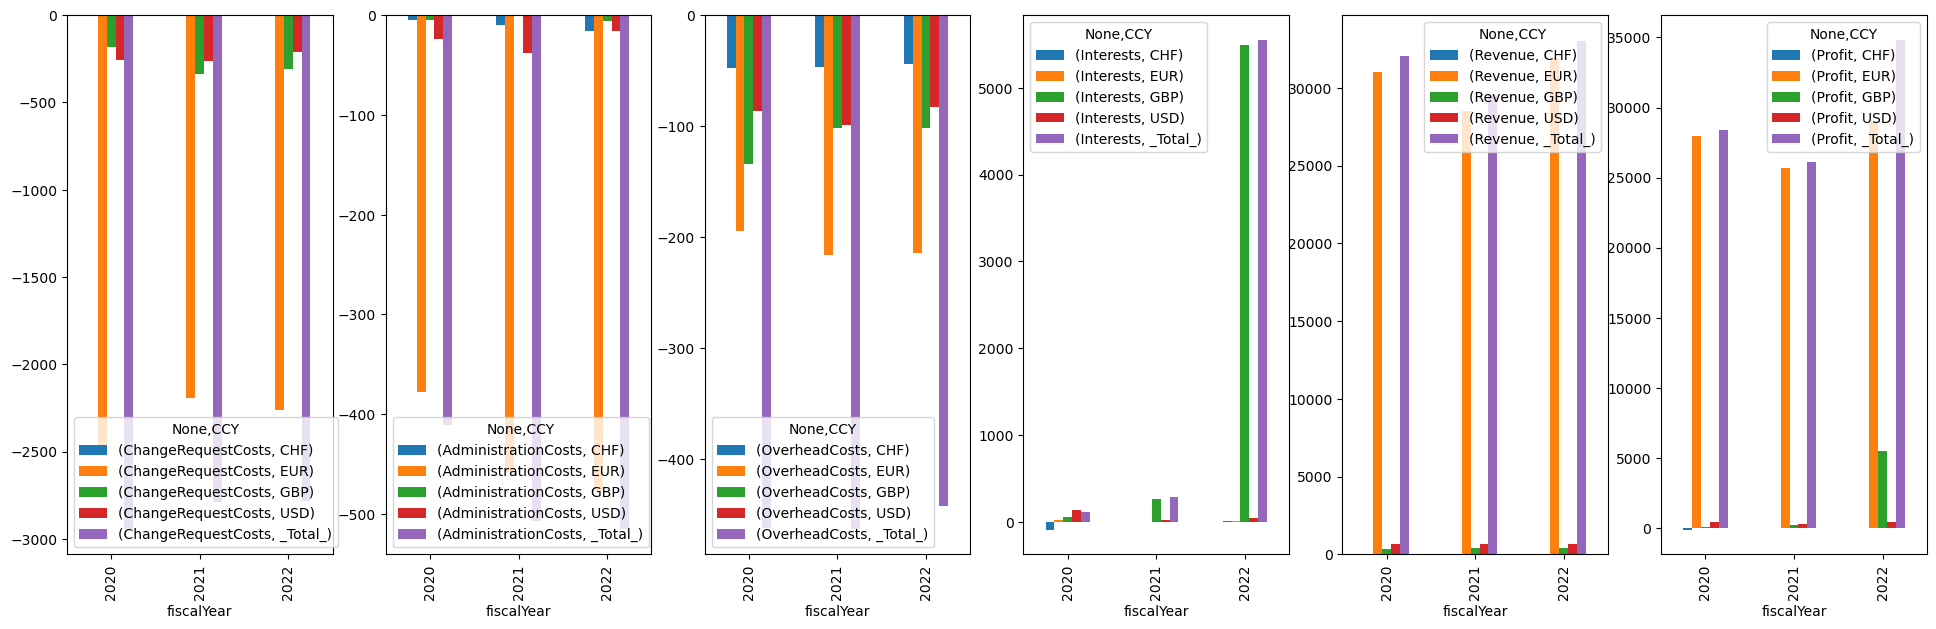

In [12]:
# Show barplots of mean metric values per year: 
fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize = (24, 7))
for i, m in enumerate(metrics):
    total_area_per_class = df[[m,'fiscalYear']].groupby(['fiscalYear','CCY']).mean()
    total_area_per_class.unstack().plot(kind='bar', ax= axs[i])


#### Boxplots of metrics per fiscal year 

Text(0.5, 0.98, 'Boxplots per fiscal year (for total across currencies)')

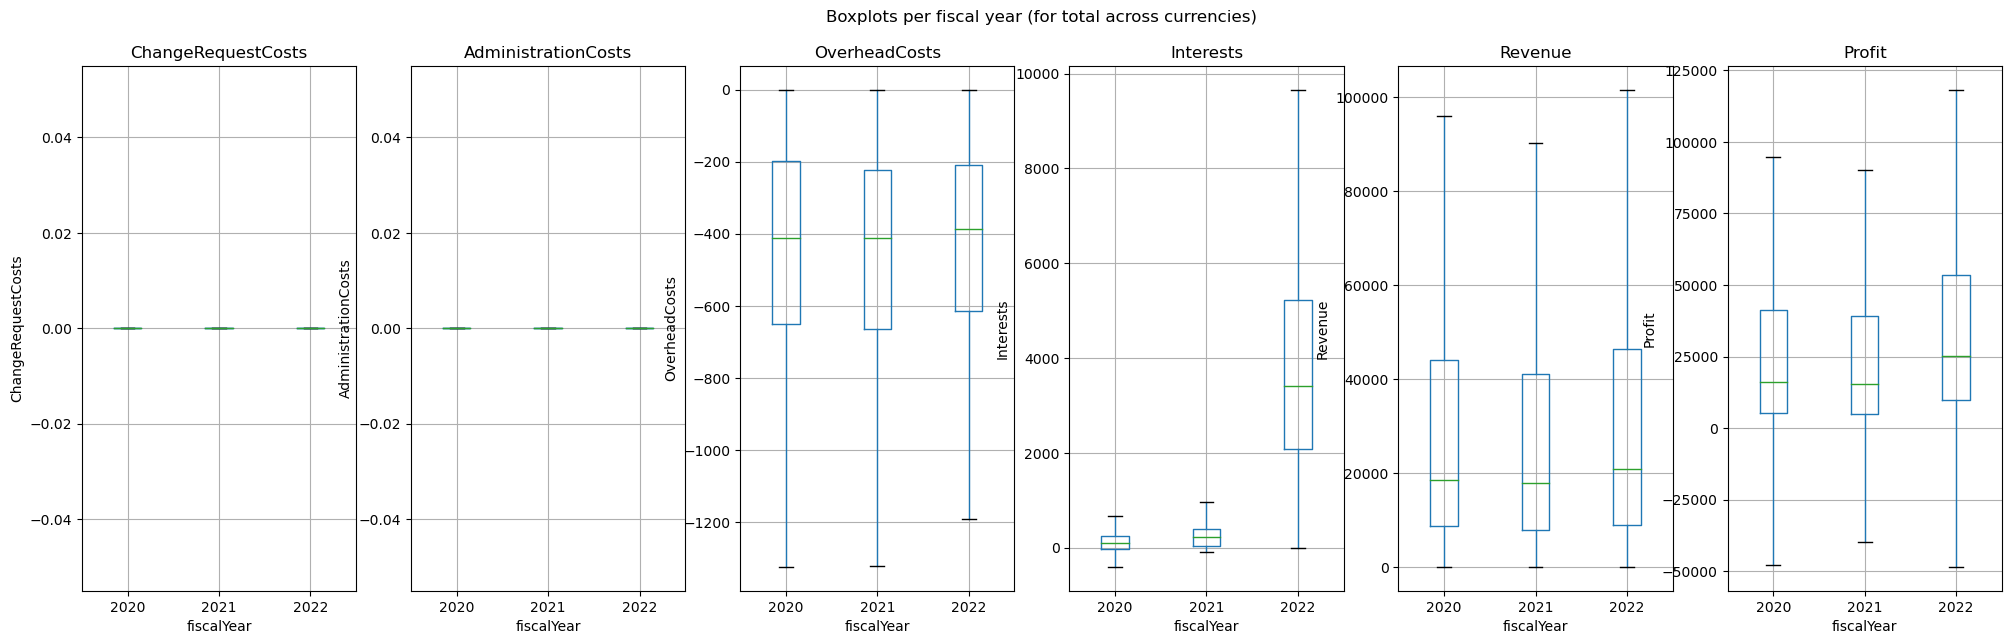

In [13]:
# Show boxplots of metrics per year: 
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize = (24, 7))
for  i, m in enumerate(metrics):
    g = df.loc[df.CCY=='_Total_',[m,'fiscalYear']].boxplot(by=['fiscalYear'],showfliers=0, ax= axs[i])
    g.set_xlabel('fiscalYear'); g.set_ylabel(m)
fig.suptitle('Boxplots per fiscal year (for total across currencies)')

#### Plot the metrics per fiscal year across time

Text(0.5, 0.98, 'Plot per fiscal year (for total across currencies)')

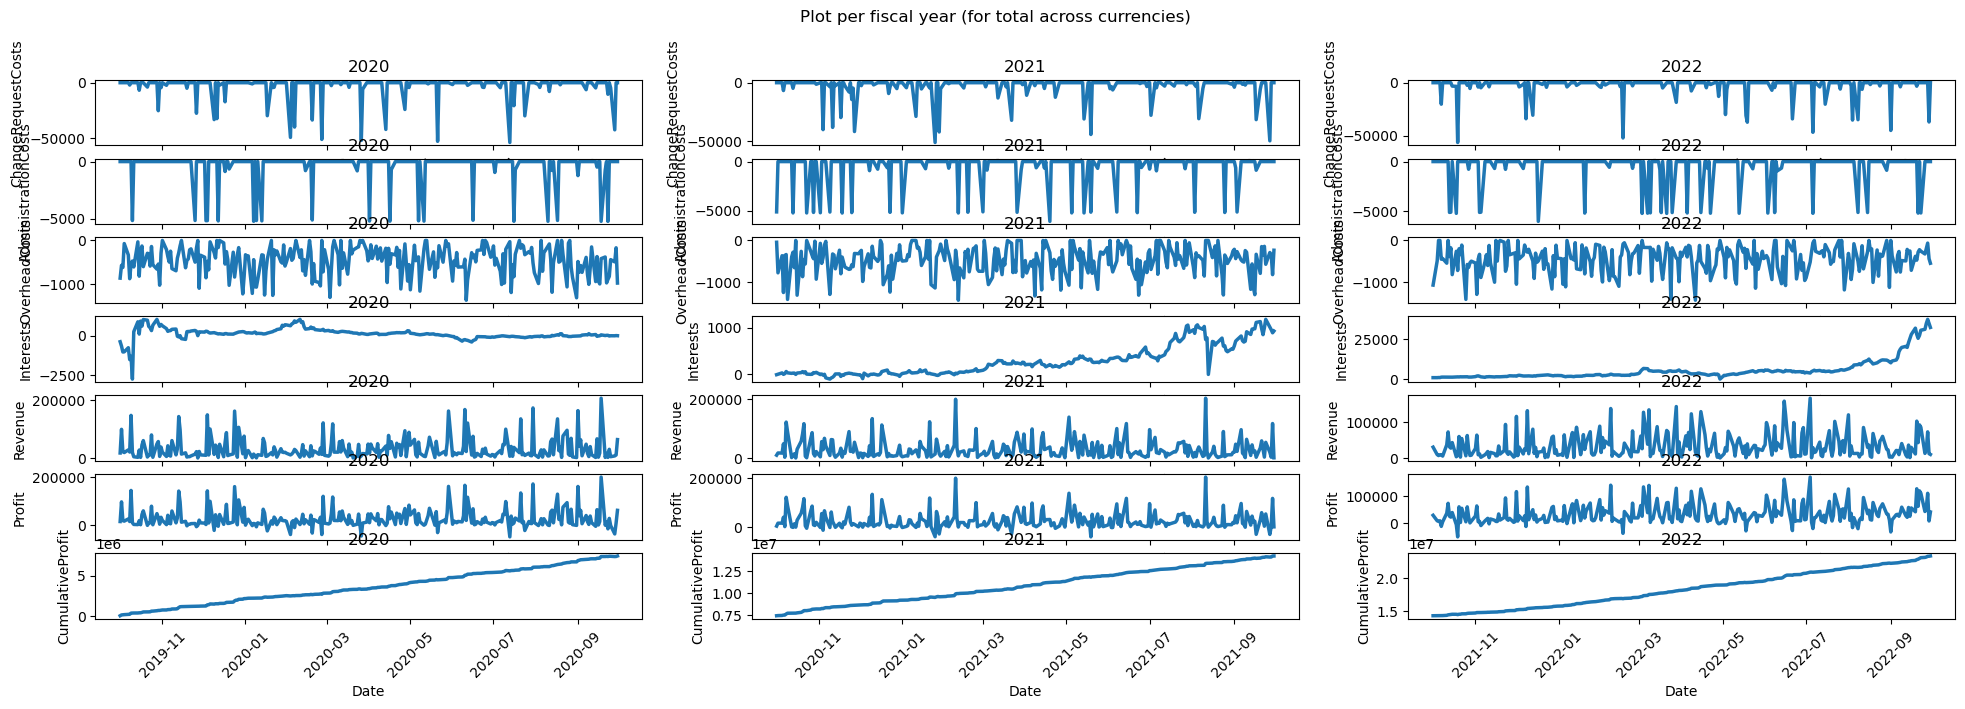

In [14]:
years = np.unique(metrics_per_year_CCY.index.get_level_values('fiscalYear'))
fig, axs = plt.subplots(nrows=len(metrics)+1, ncols=len(years), figsize = (24, 7))
for i, m in enumerate(metrics+['CumulativeProfit']):
    for j, c in enumerate(years):
        g = sns.lineplot(x='Date', y=m, data=df[(df.fiscalYear==c) & (df.CCY=='_Total_')], linewidth=2.5, ax= axs[i][j])
        axs[i][j].tick_params('x', labelrotation=45)
        g.set_title(c)
fig.suptitle('Plot per fiscal year (for total across currencies)')        

#### Autocorrelation of metrics

Text(0.5, 0.98, 'Plot per fiscal year (for total across currencies)')

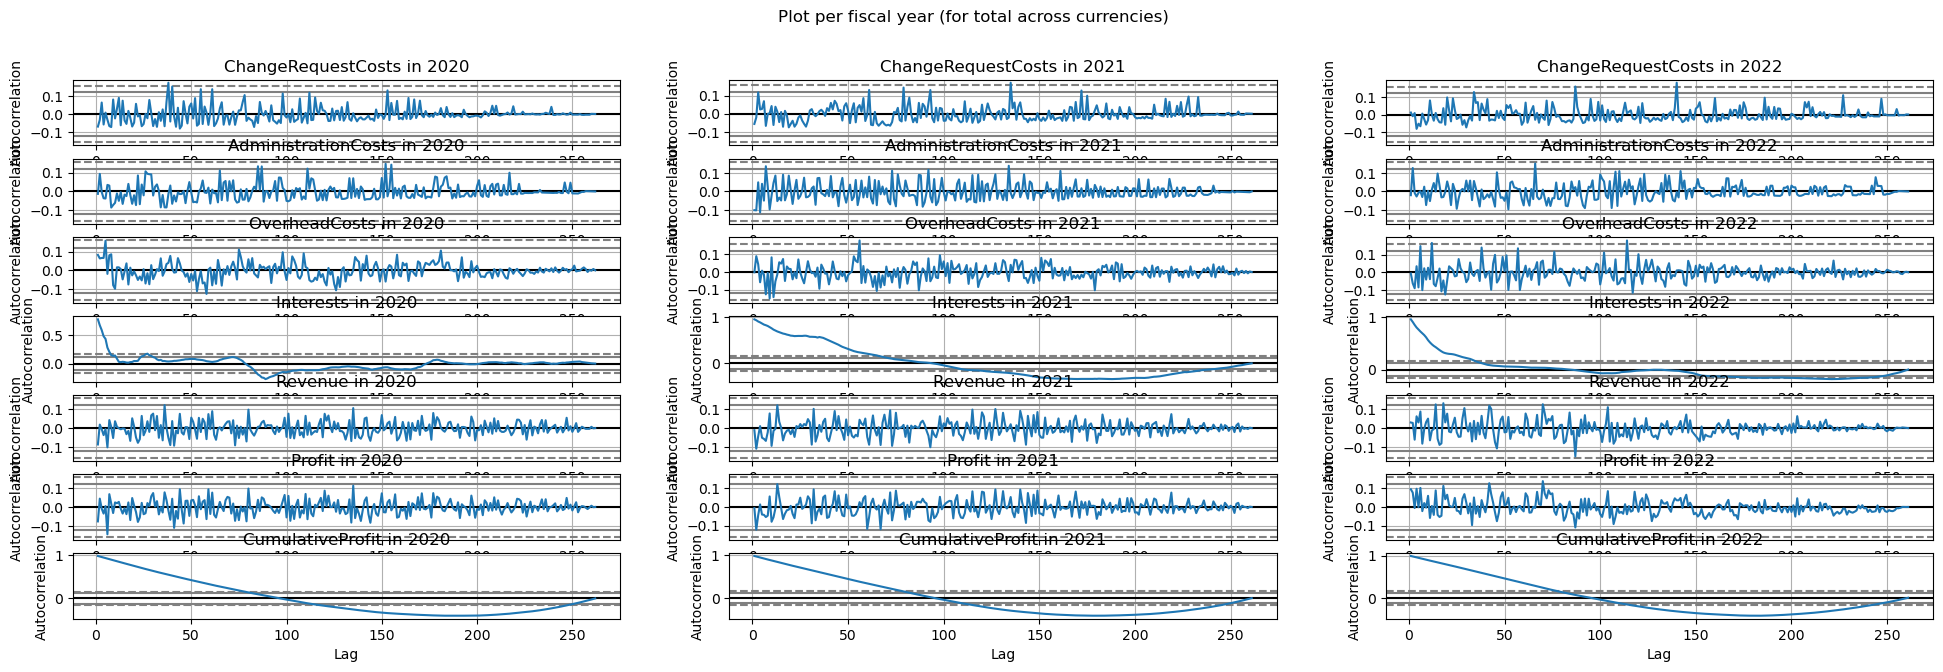

In [15]:
# Show autocorrelation plots
from pandas.plotting import autocorrelation_plot
years = np.unique(metrics_per_year_CCY.index.get_level_values('fiscalYear'))
fig, axs = plt.subplots(nrows=len(metrics)+1, ncols=len(years), figsize = (24, 7))
for i, m in enumerate(metrics+['CumulativeProfit']):
    for j, c in enumerate(years):
        autocorrelation_plot(df.loc[(df.fiscalYear==c) & (df.CCY=='_Total_'),m],ax= axs[i][j]) 
        axs[i][j].set_title(m+' in '+ str(c))
fig.suptitle('Plot per fiscal year (for total across currencies)')            

#### Decompostion of Revenue in Trend, Seasonal component and Residuals

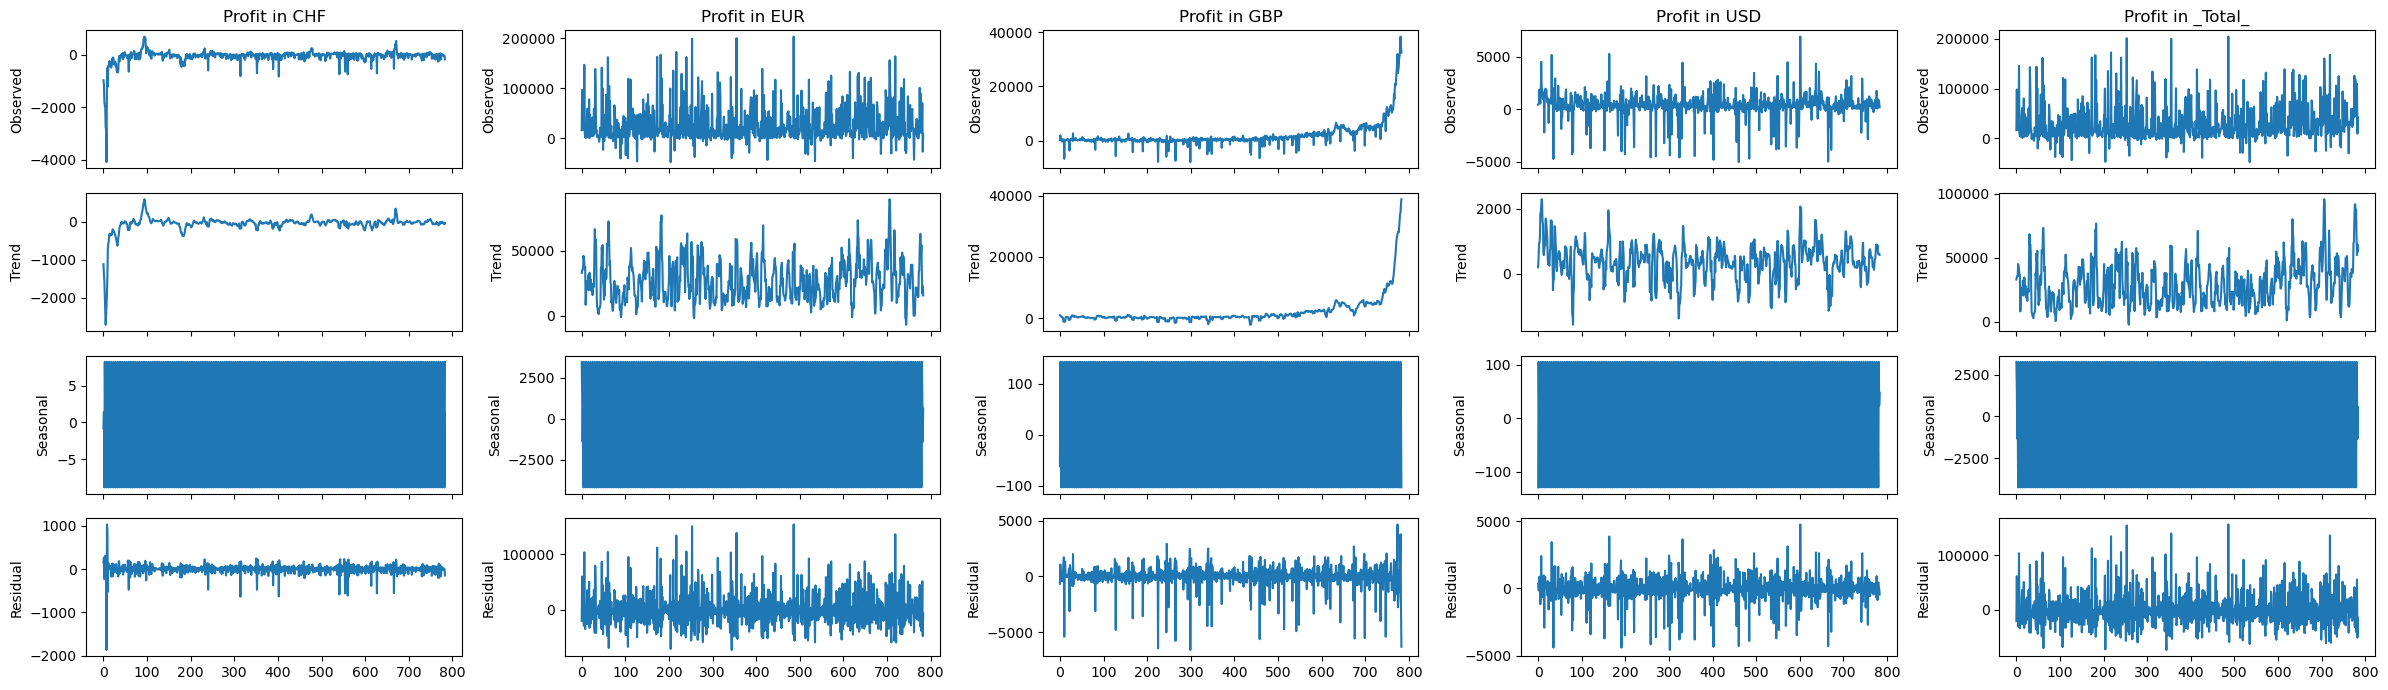

In [16]:
# use the custom function decompose_time_series:

_ = decompose_time_series(df, output_folder_plots = output_folder_plots,  y_var='Profit',  condition_variable = 'CCY')        

## Forecasting analysis

###  Prepare the data for the forcasting analysis

In [171]:
# prepare data
df1 = df.copy()

# Use cumulative profit as target variable for the forecast analysis
# Reasons: 
# - Cumulative profit is the variable of central interest.
# - Using lagged profit values and/or differencing can allow us to account for trends in the cumulative profit
# - Cumulative profit may be better suited to account for days of zero profit (e.g., due to days without observed cashflow records)

df1 = df1.rename(columns={'Profit':'y_var'})

#set date and CCY as index
df1 = df1.set_index([df1.Date, df1.CCY])

#drop date and currency column
df1 = df1.drop(['year','fiscalYear','Date','CCY'], axis=1) 

x_vars = [i for i in df1.columns if i not in ['y_var']]
print(x_vars)


['ChangeRequestCosts', 'AdministrationCosts', 'OverheadCosts', 'Interests', 'Revenue', 'CumulativeProfit']


In [175]:
look_back = 5 # number of look-back periods for LSTM model.
LOAD      = 0 # Indicates whether to load the model from a previous model training.

# replace x_vars by lagged variables:
df1 = pd.merge(df1['y_var'], df1[['y_var'] + x_vars].groupby(level='CCY').shift(1) ,left_index=True, right_index=True, suffixes=('', '_lagged'))
# rename lagged variables
df1  = df1.rename(columns={i:i+'_lagged' for i in x_vars})
x_vars = [i+'_lagged' for i in x_vars]
print(['x_vars :']+x_vars)


['x_vars :', 'ChangeRequestCosts_lagged_lagged', 'AdministrationCosts_lagged_lagged', 'OverheadCosts_lagged_lagged', 'Interests_lagged_lagged', 'Revenue_lagged_lagged', 'CumulativeProfit_lagged_lagged']


In [176]:
# add additional lagged variables for LSTM model:
if look_back > 1:
    for i in range(2,1+look_back):
        df1 = add_lagged(df1, x_vars, lag=i)

x_vars_plus = [i for i in df1.columns if i not in ['y_var']]
print(['x_vars_plus :']+x_vars_plus)

# remove rows where all values are missing
# Reason: missing data due to using lagged values.
idx = pd.IndexSlice
mask = ~df1.isna().any(axis=1)
print('Number of observations before cleaning days of missing data: %s'%len(df1))
df1 = df1.loc[idx[mask, :, :], :]
print('Number of observations before cleaning days of missing data: %s'%len(df1))

['x_vars_plus :', 'y_var_lagged', 'ChangeRequestCosts_lagged_lagged', 'AdministrationCosts_lagged_lagged', 'OverheadCosts_lagged_lagged', 'Interests_lagged_lagged', 'Revenue_lagged_lagged', 'CumulativeProfit_lagged_lagged', 'ChangeRequestCosts_lagged_lagged_lagged2', 'AdministrationCosts_lagged_lagged_lagged2', 'OverheadCosts_lagged_lagged_lagged2', 'Interests_lagged_lagged_lagged2', 'Revenue_lagged_lagged_lagged2', 'CumulativeProfit_lagged_lagged_lagged2', 'y_var_lagged_lagged2', 'ChangeRequestCosts_lagged_lagged_lagged3', 'AdministrationCosts_lagged_lagged_lagged3', 'OverheadCosts_lagged_lagged_lagged3', 'Interests_lagged_lagged_lagged3', 'Revenue_lagged_lagged_lagged3', 'CumulativeProfit_lagged_lagged_lagged3', 'y_var_lagged_lagged3', 'ChangeRequestCosts_lagged_lagged_lagged4', 'AdministrationCosts_lagged_lagged_lagged4', 'OverheadCosts_lagged_lagged_lagged4', 'Interests_lagged_lagged_lagged4', 'Revenue_lagged_lagged_lagged4', 'CumulativeProfit_lagged_lagged_lagged4', 'y_var_lagged_

In [177]:
# split the data in a training and a test set:
horizon = 30
#take last week of the dataset for validation
inx_day = np.unique(df1.index.get_level_values('Date'))[-horizon]

df1_train, df1_test = df1.iloc[df1.index.get_level_values('Date')<inx_day], df1.iloc[df1.index.get_level_values('Date')>=inx_day]


#### Autoregressive moving average model

#### Differencing needed?

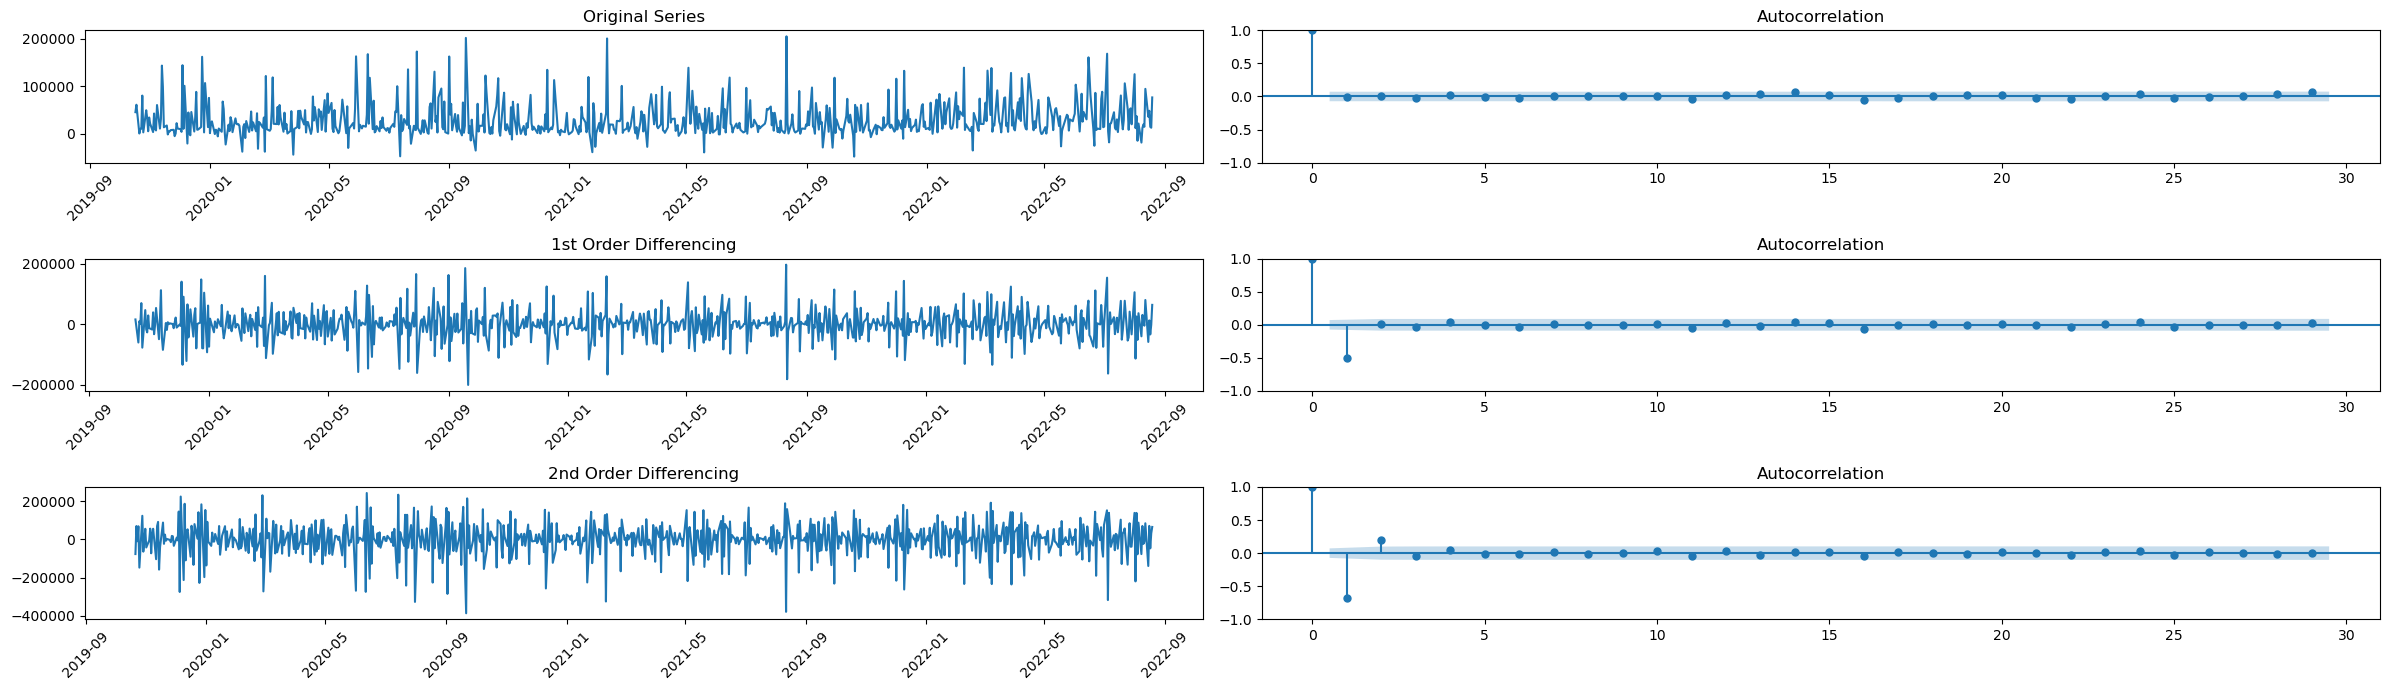

In [178]:
# visual inspection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(24,7)}) 

y_train_total = df1_train[df1_train.index.get_level_values('CCY')=='_Total_'].y_var.droplevel('CCY')

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(y_train_total); axes[0, 0].set_title('Original Series')
axes[0, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_train_total.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_train_total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()


In [179]:
# run tests:
from pmdarima.arima.utils import ndiffs

## Adf Test
print(ndiffs(y_train_total, test='adf')  )

# KPSS test
print(ndiffs(y_train_total, test='kpss') ) 

# PP test:
print(ndiffs(y_train_total, test='pp')  )

0
1
0


Visual inspection and tests indicate that 1st order differencing is needed for a stationary time series. 

#### Autocorrelation?

[(0.0, 1.2)]

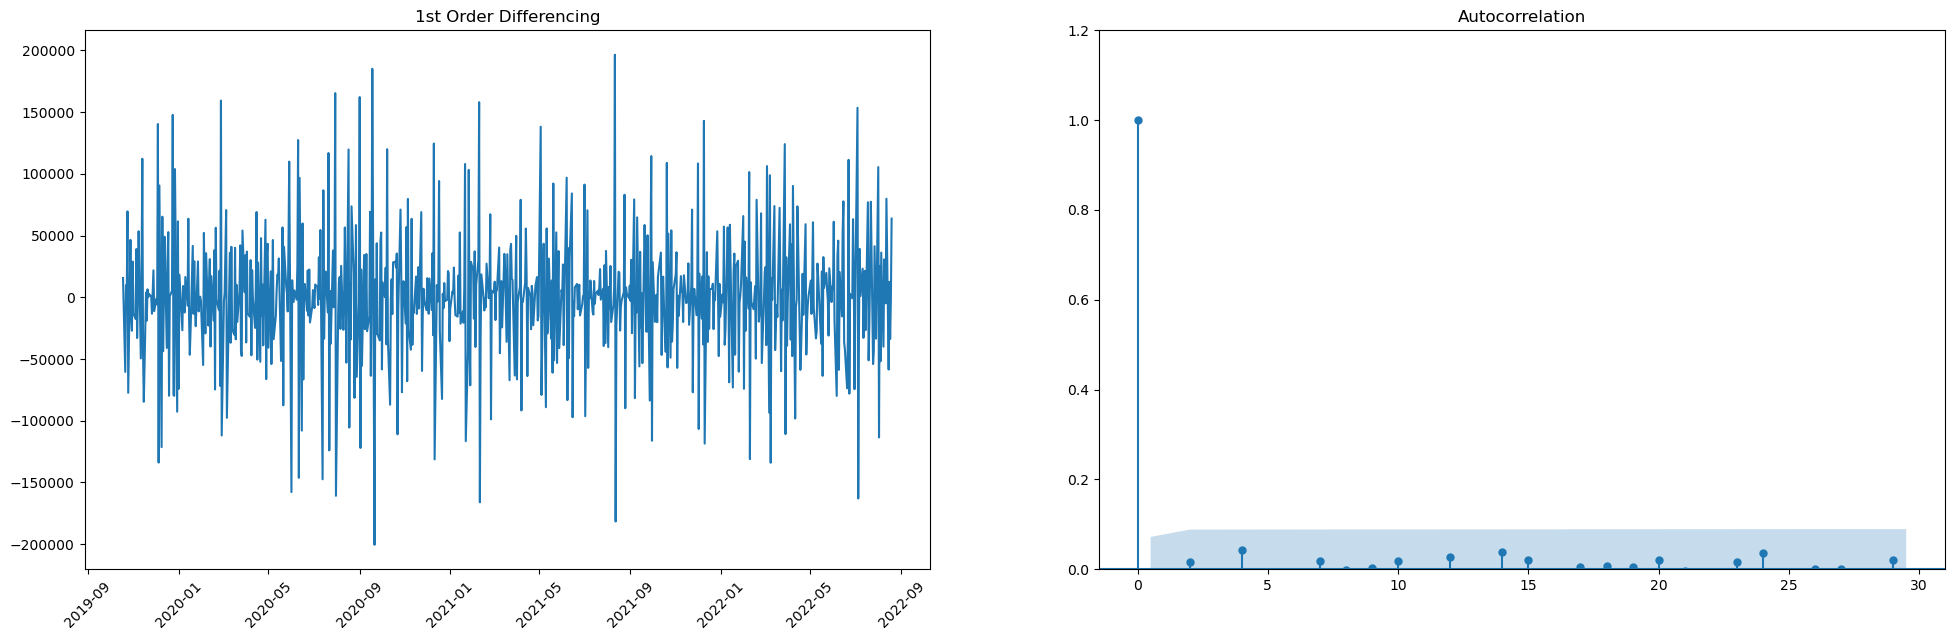

In [180]:
plt.rcParams.update({'figure.figsize':(24,7)})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train_total); axes[0].set_title('Observations')
#axes[0].plot(y_train_total.diff()); axes[0].set_title('1st Order Differencing')
plot_acf(y_train_total.diff().dropna(), ax=axes[1])
axes[0].tick_params('x', labelrotation=45)
axes[1].set(ylim=(0,1.2))

The autocorrelation plot does not indicate autocorrelation of the time series.

#### Partial Autocorrelation?

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[(0.0, 5.0)]

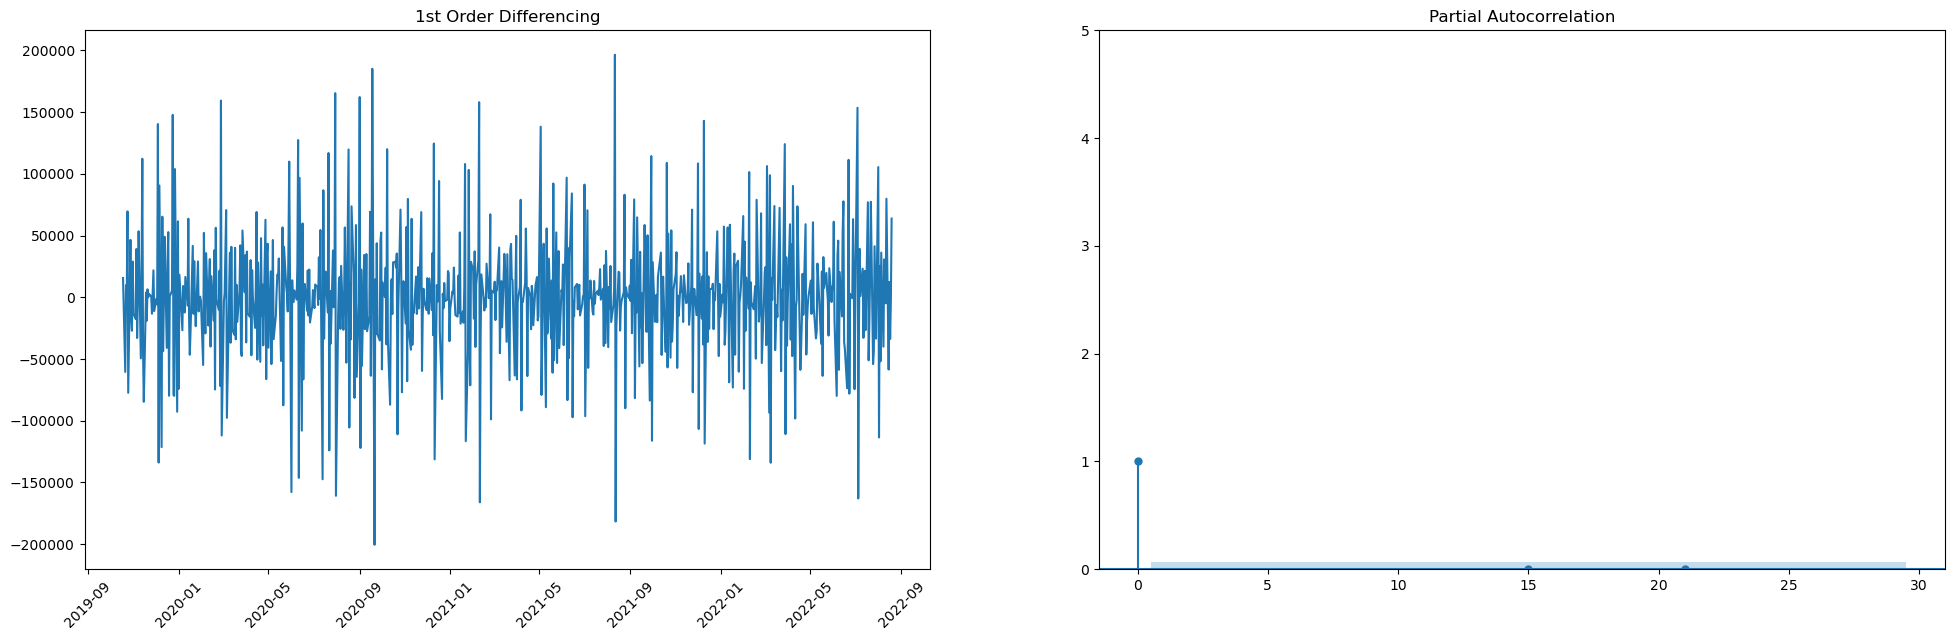

In [181]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(24,7)})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train_total); axes[0].set_title('Observations')
#axes[0].plot(y_train_total.diff()); axes[0].set_title('1st Order Differencing')
axes[0].tick_params('x', labelrotation=45)
plot_pacf(y_train_total.diff().dropna(), ax=axes[1])
axes[1].set(ylim=(0,5))



The partial autocorrelation plot does not indicate partial autocorrelation of the time series.

### SARIMA with exogoneous variables

In [182]:
# initialize results variables 
smodels       = dict()
res_stats_in  = res_stats_out =  res_stats_out_train_only =pd.DataFrame()

# set the considered currencies
currencies =  ['EUR', 'USD', 'GBP', 'CHF','_Total_']


In [183]:
# run the SARIMA model
# SARIMA stands for Seasonal Autoregressive Integrated Moving Average 
# use a seasonal differencing of m=5 for the daily data (there is no data for Saturday and Sunday).
for c in currencies:
    smodels = get_arima(df1_train, smodels, x_vars, c = c, output_folder_model =  output_folder_model, LOAD = LOAD)


----------------------------------------------------------------------------------------------------
SARIMA model for EUR

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(1,0,1)[5] intercept   : AIC=17734.160, Time=1.97 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=17722.006, Time=0.59 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=17725.811, Time=1.09 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=17726.154, Time=1.68 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=21893.691, Time=1.01 sec
 ARIMA(0,0,0)(1,0,0)[5] intercept   : AIC=17723.761, Time=2.21 sec
 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=17723.889, Time=1.32 sec
 ARIMA(0,0,0)(1,0,1)[5] intercept   : AIC=17725.613, Time=2.46 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=17724.035, Time=0.64 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=17724.270, Time=0.76 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=17730.336, Time=0.78 sec

Best model:  ARIMA(0,0,0)(0,0,0)[5] intercept
Total fit time: 14.540 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  742
Model:                     

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


 ARIMA(1,0,1)(1,0,1)[5] intercept   : AIC=17724.020, Time=7.29 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=17737.497, Time=0.80 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=17741.410, Time=2.21 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=17741.748, Time=3.63 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=21908.902, Time=0.50 sec
 ARIMA(1,0,1)(0,0,1)[5] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,0,1)(1,0,0)[5] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(1,0,1)(2,0,1)[5] intercept   : AIC=inf, Time=4.47 sec
 ARIMA(1,0,1)(1,0,2)[5] intercept   : AIC=inf, Time=8.01 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=17746.508, Time=2.42 sec
 ARIMA(1,0,1)(0,0,2)[5] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(1,0,1)(2,0,0)[5] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(1,0,1)(2,0,2)[5] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=17743.465, Time=3.32 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=17743.205, Time=3.05 sec
 ARIMA(2,0,1)(1,0,1)[5] intercept   :

#### In-Sample performance

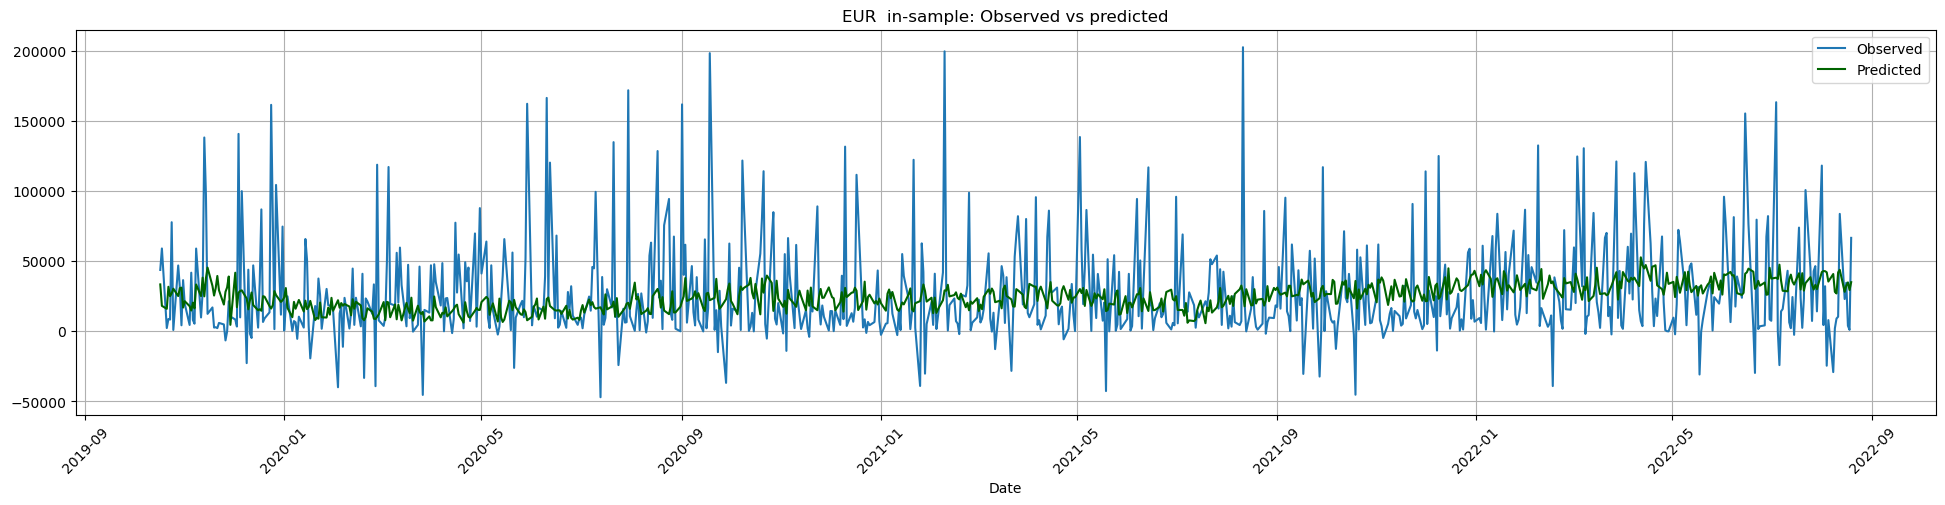

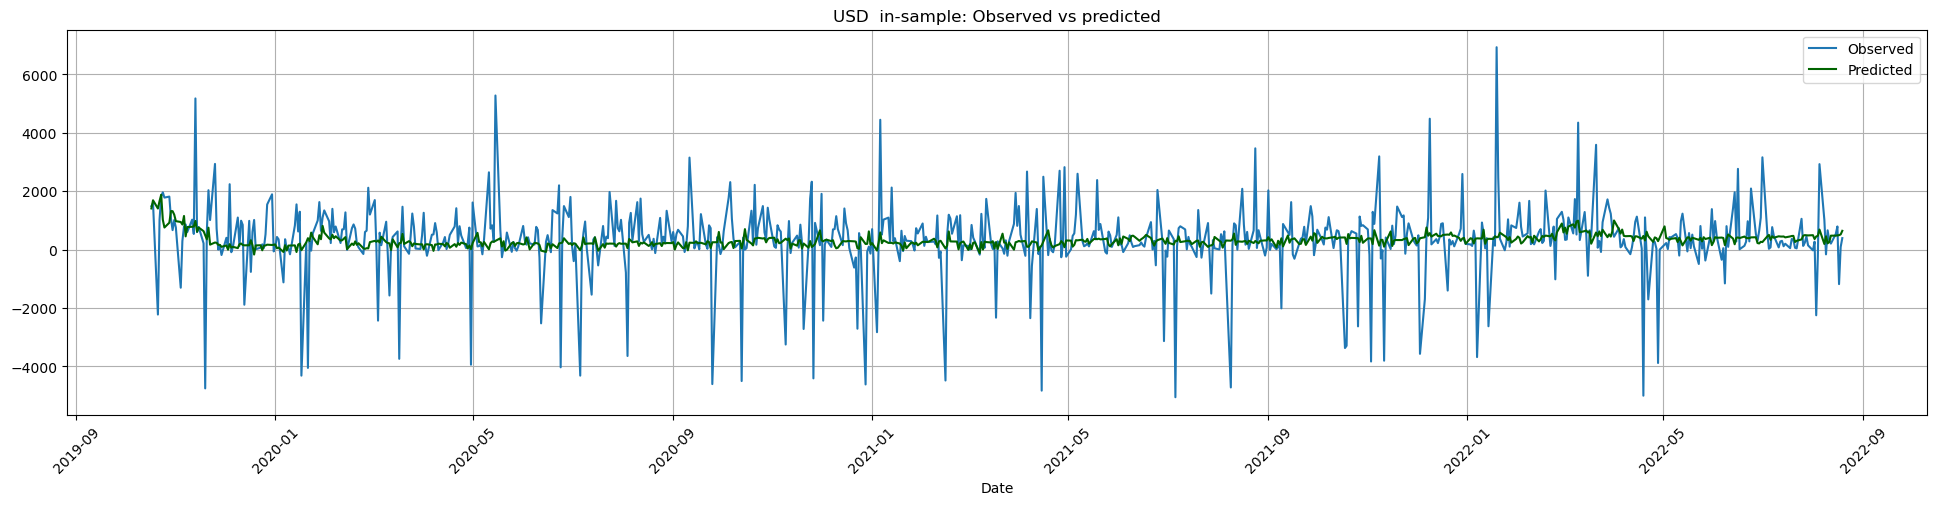

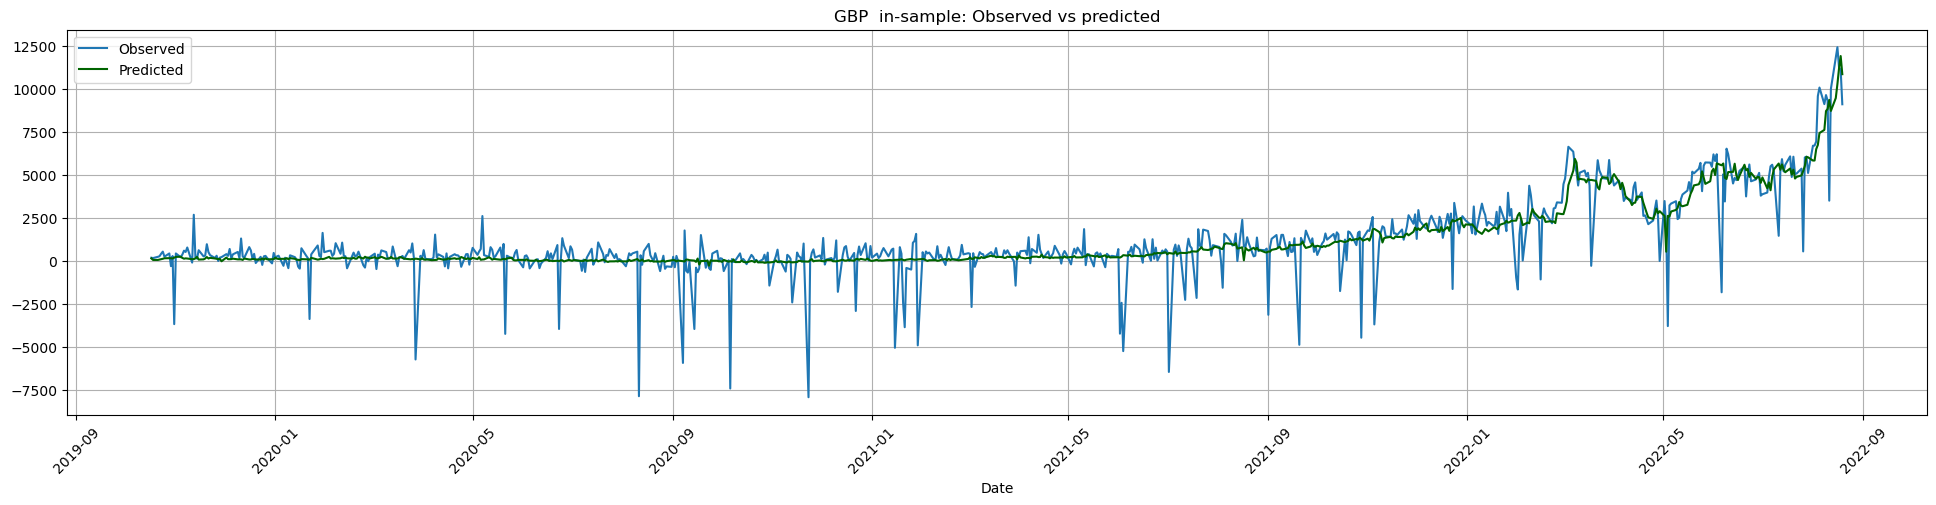

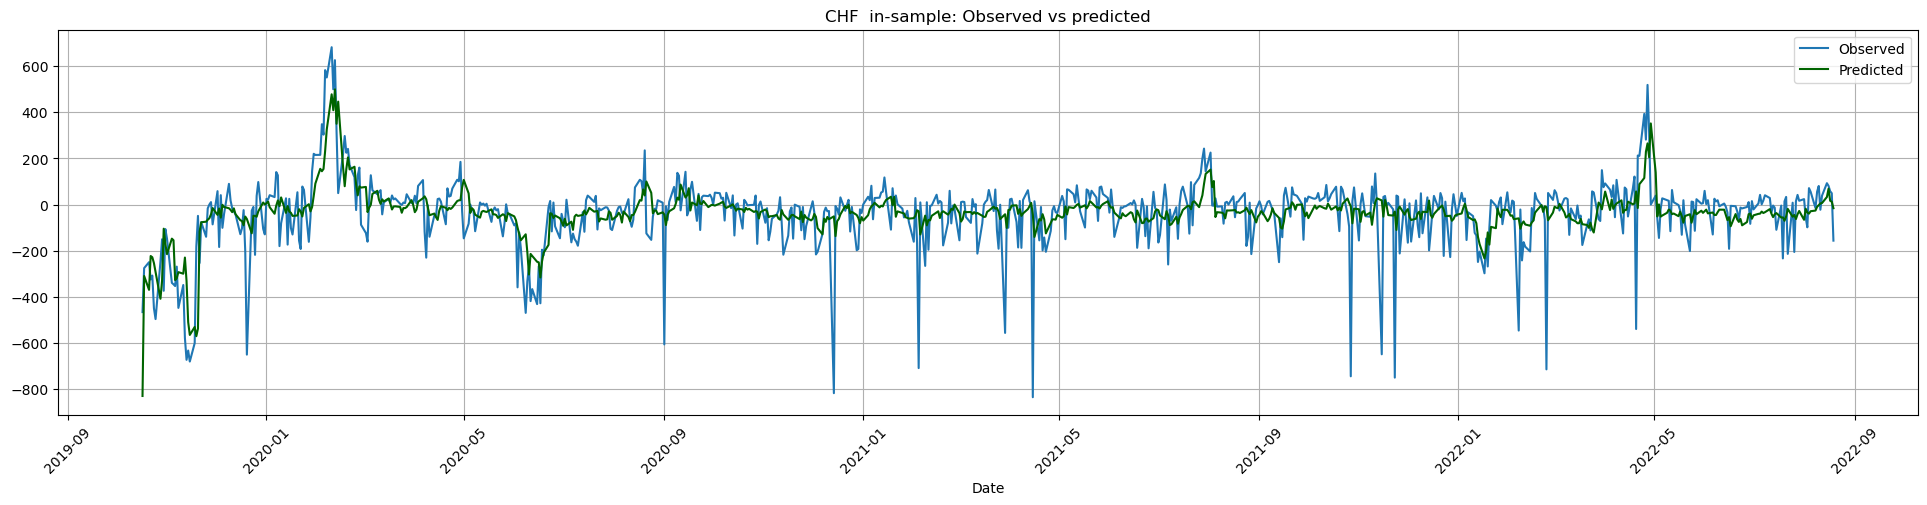

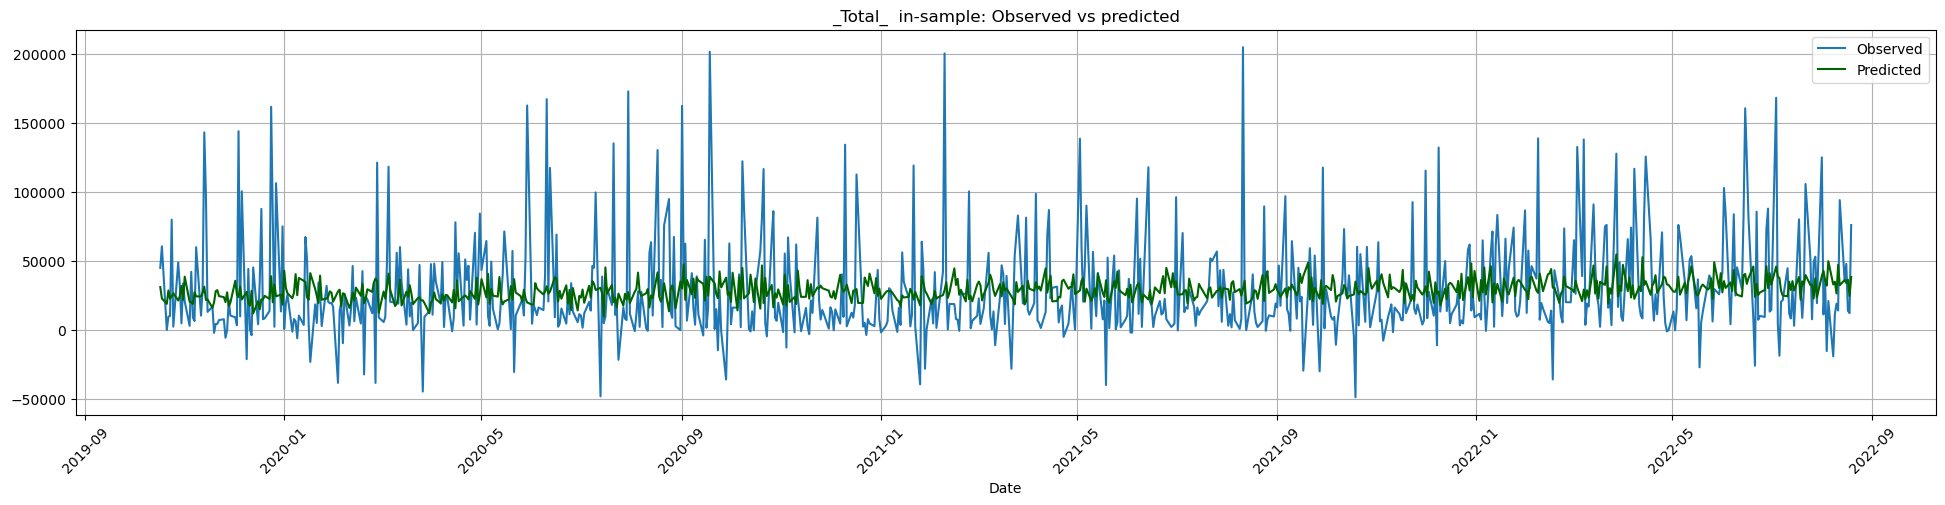

In [184]:
for c in currencies:
    res_stats_in = get_error_stats_in(df1_train, smodels, df, res_stats_in, x_vars, c = c)

In [185]:
# show in-sample error statistics:
# adjust display settings:
pd.options.display.float_format =  '{:,.1f}'.format
res_stats_in

EUR                     USD  \
Root mean squared error                    36,765.8                 1,222.9   
Mean squared error                  1,351,722,837.2             1,495,451.5   
Mean absolute error                        26,391.7                   711.9   
Median absolute error                      19,727.9                   365.8   
Mean absolute prctg error 721,308,198,473,387,392.0 9,471,527,253,458,220.0   
Explained variance                             -0.0                     0.0   
Correlation                                     0.1                     0.1   

                                               GBP                     CHF  \
Root mean squared error                    1,267.9                   127.5   
Mean squared error                     1,607,480.8                16,248.9   
Mean absolute error                          661.1                    84.5   
Median absolute error                        353.5                    63.9   
Mean absolute prctg error 23,009,268,063,675,832.0 2,817,643,292,990,949.5   
Explained variance                             0.7                     0.3   
Correlation                                    0.8                     0.6   

                                            _Total_  
Root mean squared error                    36,605.1  
Mean squared error                  1,339,929,952.6  
Mean absolute error                        26,880.7  
Median absolute error                      20,303.5  
Mean absolute prctg error 605,012,665,594,075,520.0  
Explained variance                             -0.0  
Correlation                                     0.1

#### Forecast: Out-of-Sample peformance

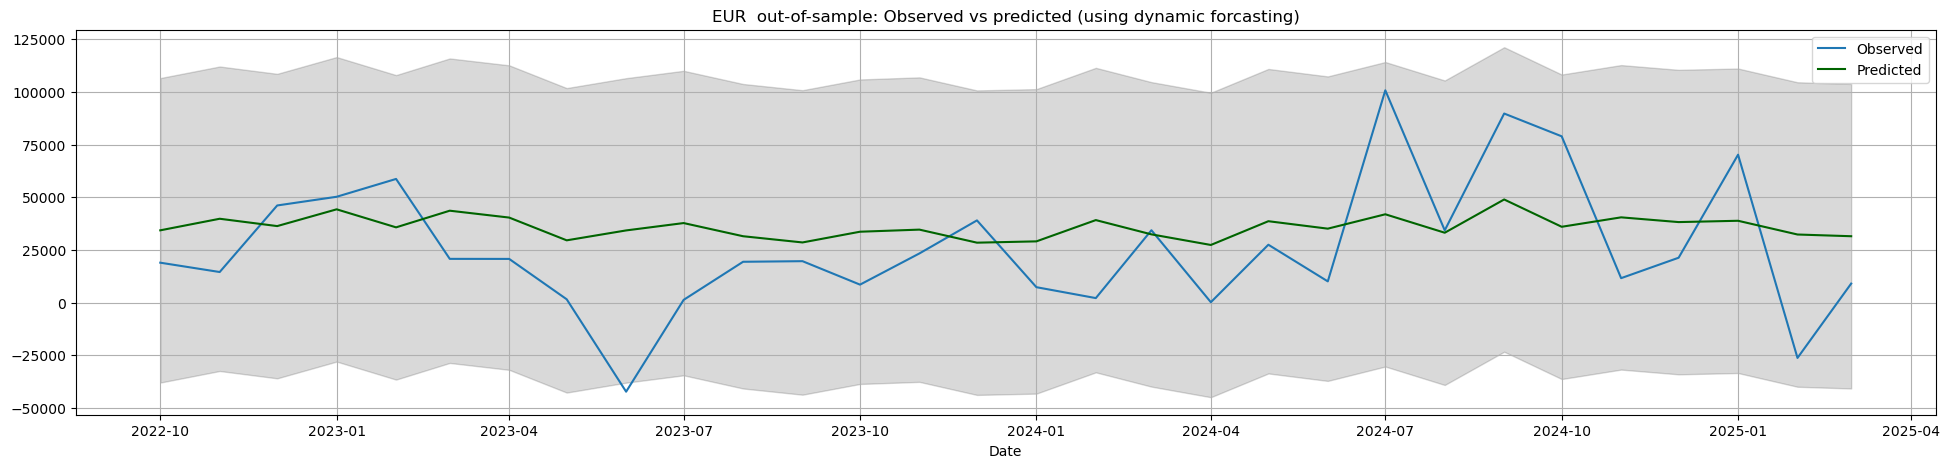

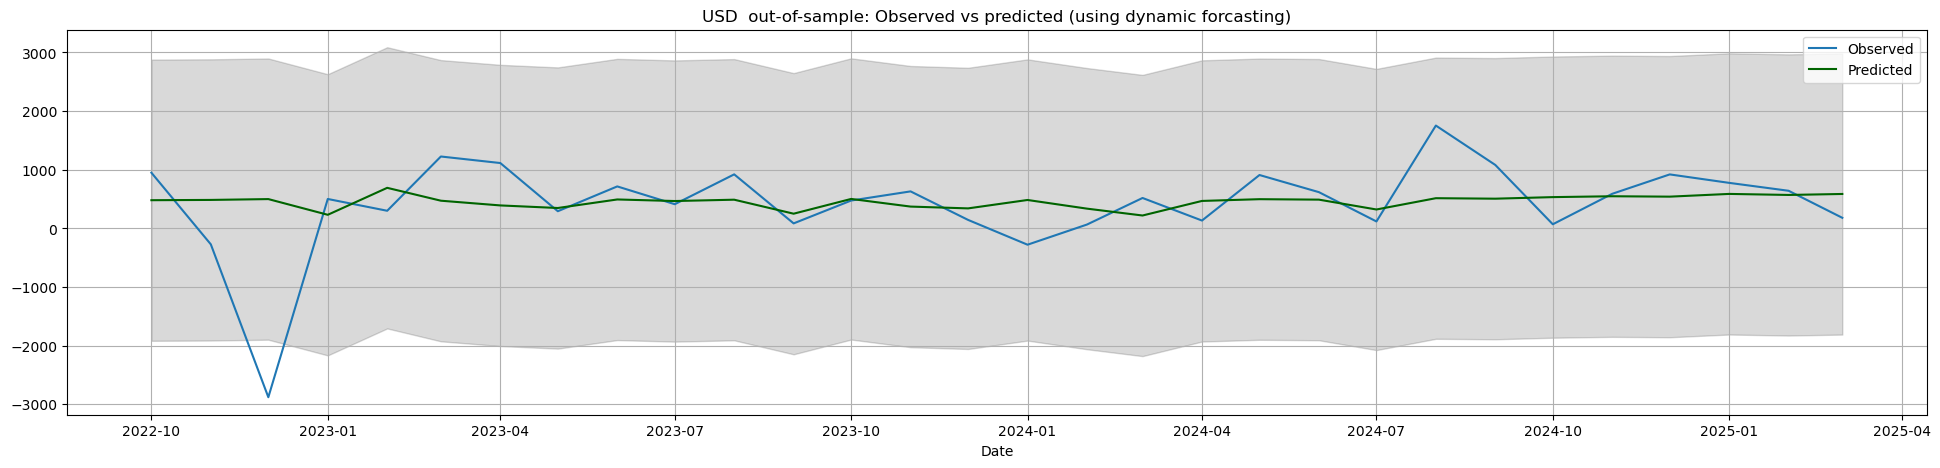

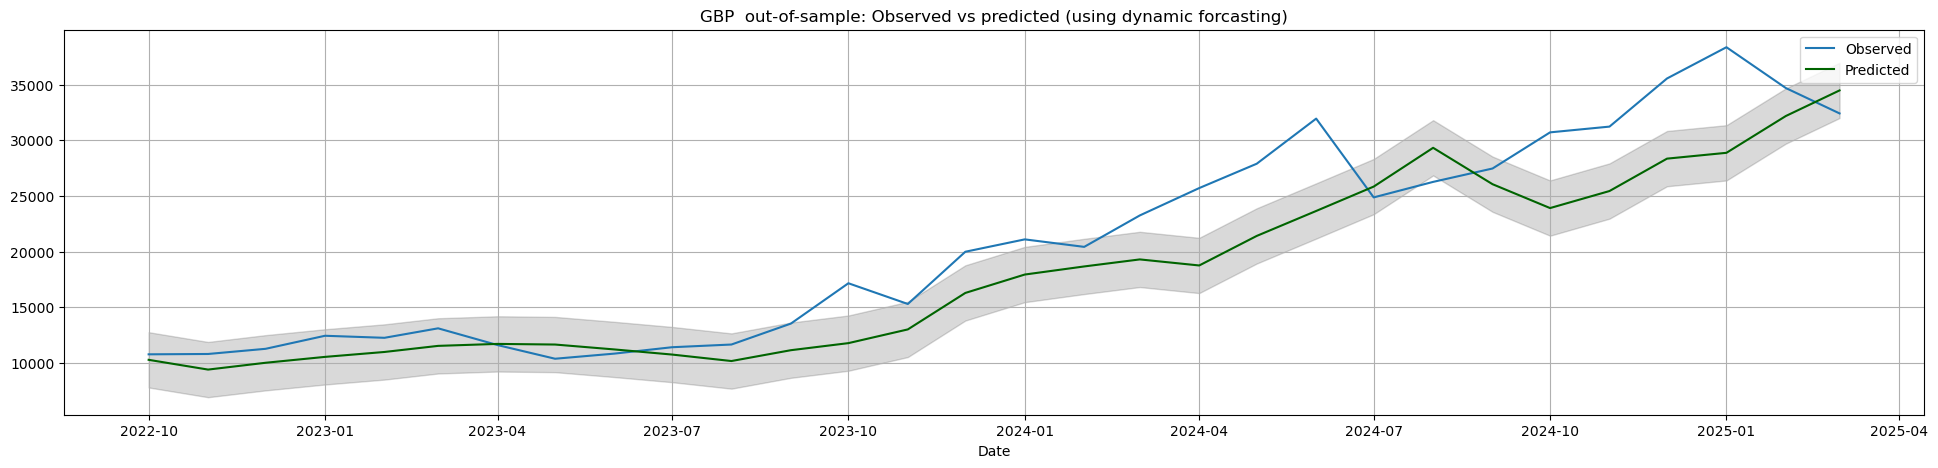

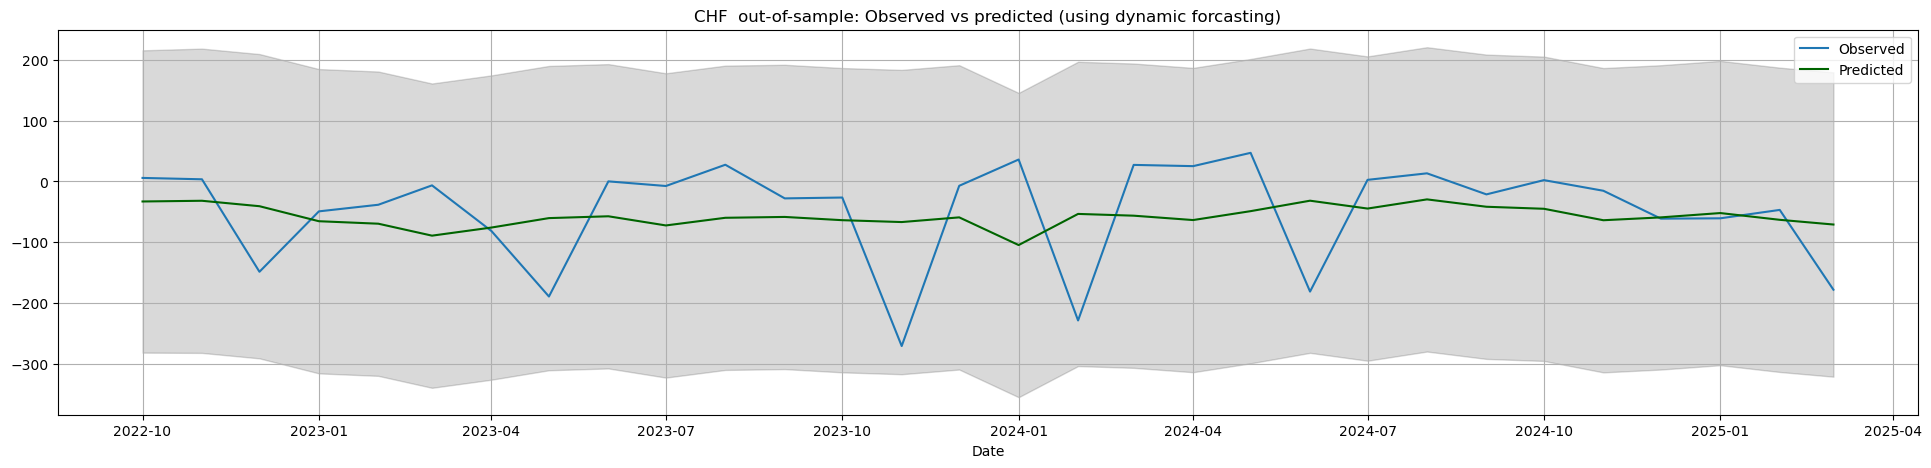

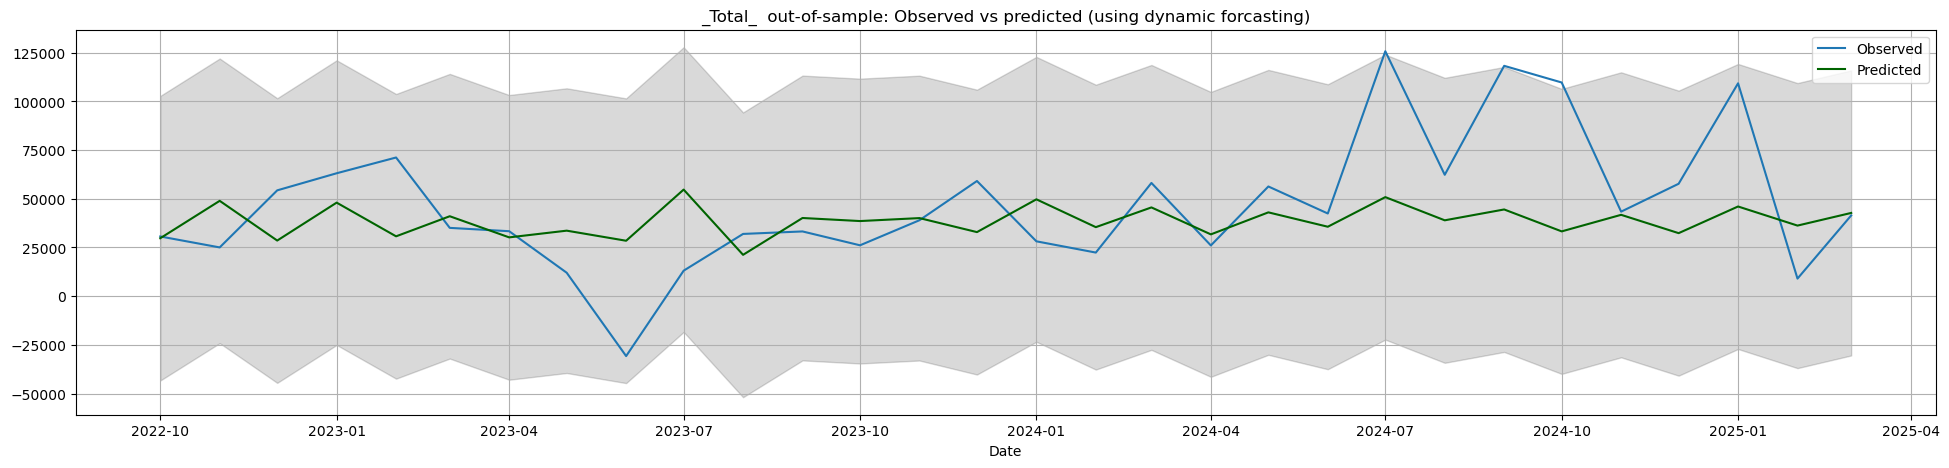

In [186]:
# Using dynamic forecasting:
for c in currencies:    
    res_stats_out = get_error_stats_out(df1_test, smodels, df, res_stats_out, x_vars, horizon,  c = c)

In [187]:
# show out-of-sample error statistics using dynamic forecasting:
res_stats_out

EUR       USD          GBP     CHF  \
Root mean squared error        30,478.5     761.9      4,093.9    85.4   
Mean squared error        928,939,423.3 580,415.9 16,759,865.1 7,288.7   
Mean absolute error            25,232.4     464.3      3,184.4    68.5   
Median absolute error          22,924.3     316.7      2,177.2    50.2   
Mean absolute prctg error           8.0       1.2          0.1    27.8   
Explained variance                  0.1      -0.0          0.9    -0.1   
Correlation                         0.5       0.1          0.9    -0.0   

                                  _Total_  
Root mean squared error          33,537.7  
Mean squared error        1,124,774,391.2  
Mean absolute error              24,512.8  
Median absolute error            18,321.0  
Mean absolute prctg error             0.7  
Explained variance                    0.1  
Correlation                           0.3

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


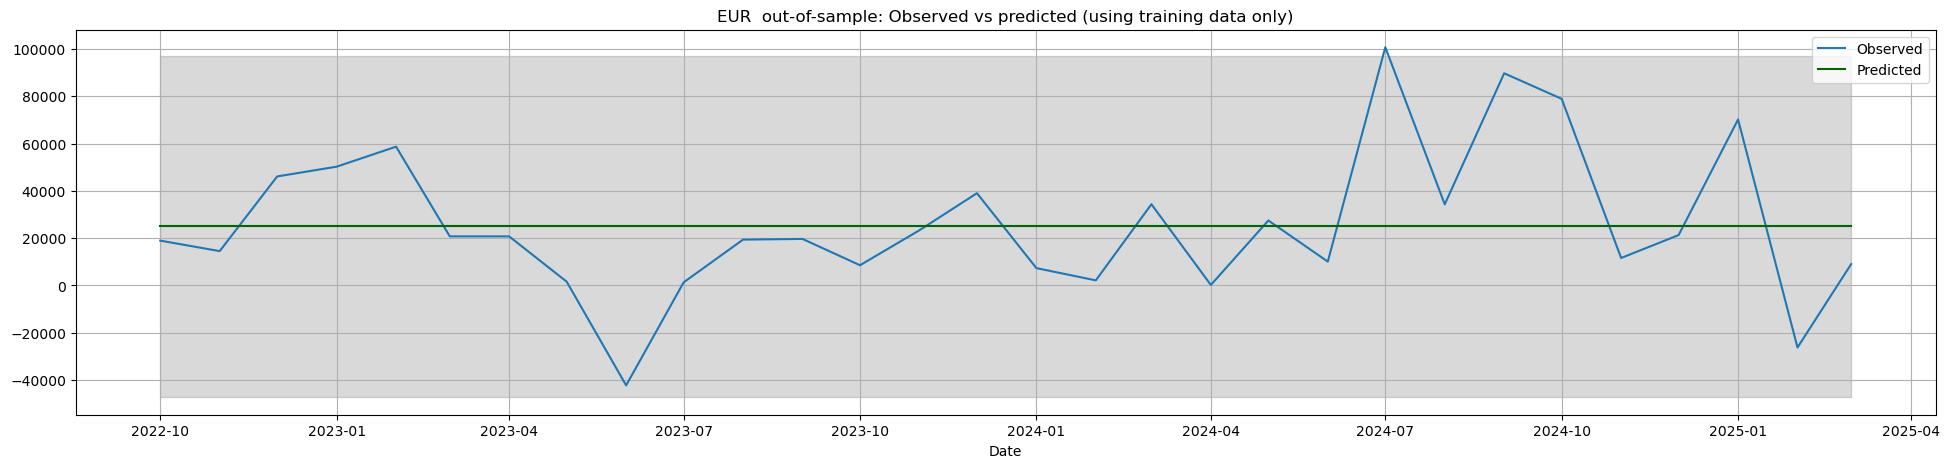

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


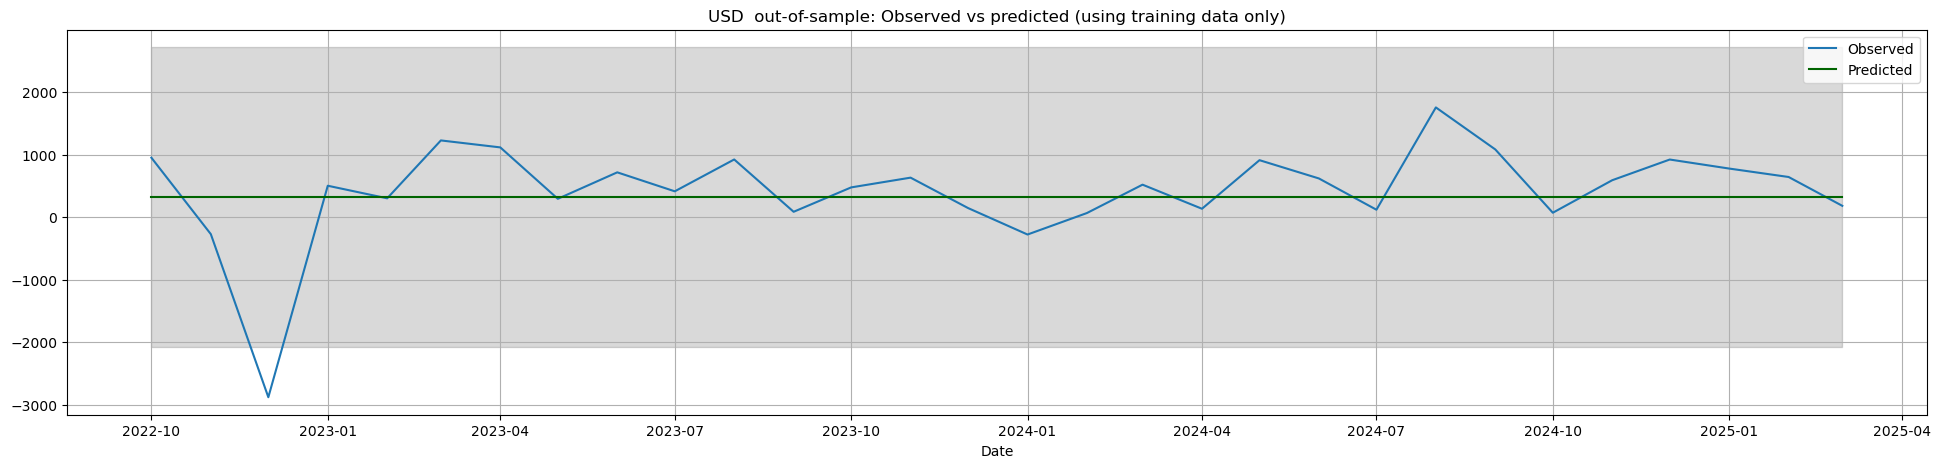

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


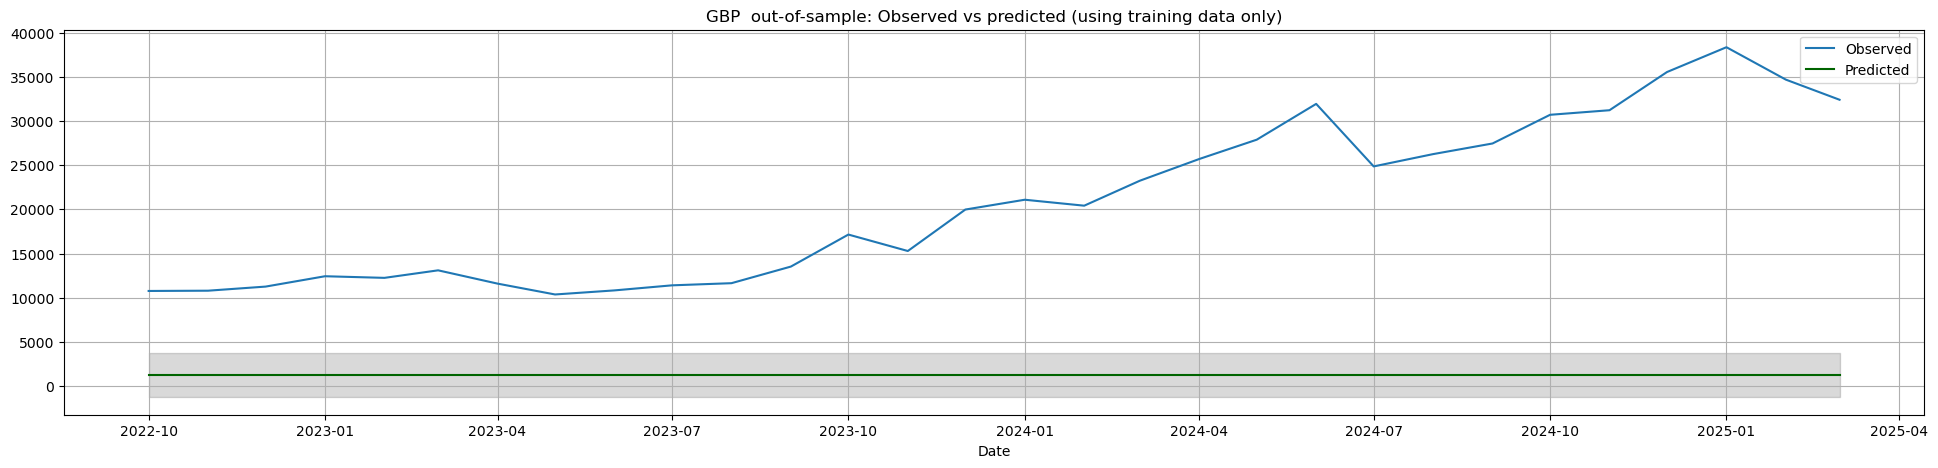

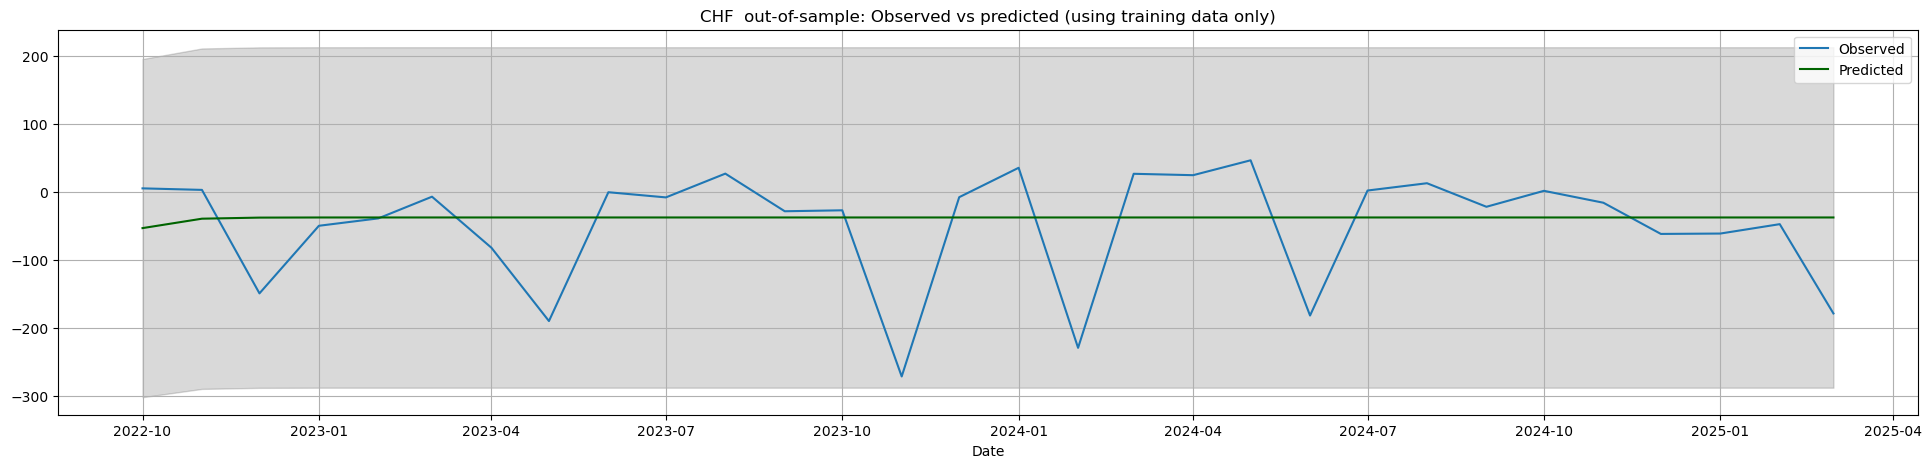

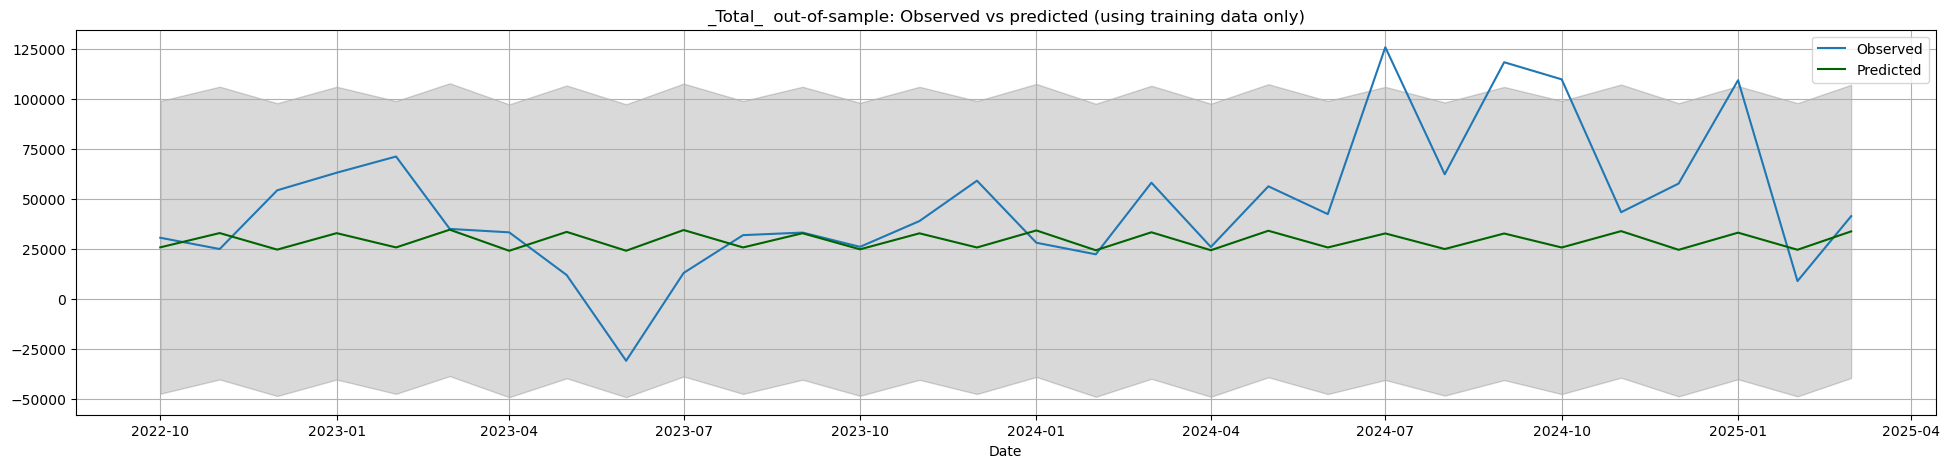

In [188]:
# Using training data only:
for c in currencies:
    res_stats_out_train_only = get_error_stats_out(df1_test, smodels, res_stats_out_train_only, x_vars, horizon, c = c, DYNAMIC_FORCASTING = 0, df1_train = df1_train)

In [189]:
# show out-of-sample error statistics using training data only:
res_stats_out_train_only

EUR       USD           GBP     CHF  \
Root mean squared error        30,764.4     766.9      21,558.9    83.9   
Mean squared error        946,449,877.7 588,159.4 464,785,804.5 7,047.5   
Mean absolute error            22,929.4     496.2      19,602.3    61.7   
Median absolute error          16,198.3     306.3      18,995.3    41.0   
Mean absolute prctg error           6.7       1.0           0.9    18.6   
Explained variance                 -0.0       0.0           0.0    -0.0   
Correlation                         NaN      -0.0          -0.1    -0.1   

                                  _Total_  
Root mean squared error          37,520.8  
Mean squared error        1,407,813,150.5  
Mean absolute error              26,249.1  
Median absolute error            19,034.0  
Mean absolute prctg error             0.5  
Explained variance                    0.0  
Correlation                           0.2

### Long Short-Term Memory Network

The Long Short-Term Memory network is a recurrent neural network.

LSTM networks use memory blocks - instead of neurons - connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence, and each gate within a block uses the sigmoid activation units to control whether it is triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

*    Forget Gate: conditionally decides what information to throw away from the block
*    Input Gate: conditionally decides which values from the input to update the memory state
*    Output Gate: conditionally decides what to output based on input and the memory of the block


In [190]:
# setup 

print(x_vars_plus)

# set the considered currencies
currencies =  ['EUR', 'USD', 'GBP', 'CHF','_Total_']

# initialize results variables 
rnn_results       = dict()
res_stats_in_rnn  = res_stats_out_rnn  =pd.DataFrame()

['y_var_lagged', 'ChangeRequestCosts_lagged_lagged', 'AdministrationCosts_lagged_lagged', 'OverheadCosts_lagged_lagged', 'Interests_lagged_lagged', 'Revenue_lagged_lagged', 'CumulativeProfit_lagged_lagged', 'ChangeRequestCosts_lagged_lagged_lagged2', 'AdministrationCosts_lagged_lagged_lagged2', 'OverheadCosts_lagged_lagged_lagged2', 'Interests_lagged_lagged_lagged2', 'Revenue_lagged_lagged_lagged2', 'CumulativeProfit_lagged_lagged_lagged2', 'y_var_lagged_lagged2', 'ChangeRequestCosts_lagged_lagged_lagged3', 'AdministrationCosts_lagged_lagged_lagged3', 'OverheadCosts_lagged_lagged_lagged3', 'Interests_lagged_lagged_lagged3', 'Revenue_lagged_lagged_lagged3', 'CumulativeProfit_lagged_lagged_lagged3', 'y_var_lagged_lagged3', 'ChangeRequestCosts_lagged_lagged_lagged4', 'AdministrationCosts_lagged_lagged_lagged4', 'OverheadCosts_lagged_lagged_lagged4', 'Interests_lagged_lagged_lagged4', 'Revenue_lagged_lagged_lagged4', 'CumulativeProfit_lagged_lagged_lagged4', 'y_var_lagged_lagged4', 'Change

In [193]:
# reload functions from utility
reload(sys.modules['utility'])
from utility import *

In [192]:
# get the lstm model(s):
for c in currencies:
    rnn_results[c] = get_lstm(df1_train, df1_test , x_vars_plus, x_vars = x_vars, c = c, PRINT = 1, LOAD = LOAD , output_folder_model = output_folder_model, look_back = look_back)
 


----------------------------------------------------------------------------------------------------
LSTM RNN model for EUR



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1)                 36        
                                                                 
 dense_13 (Dense)            (None, 1)                 2         
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________
None

Start training ...



UnboundLocalError: cannot access local variable 'X_test_s' where it is not associated with a value

#### In-Sample Performance

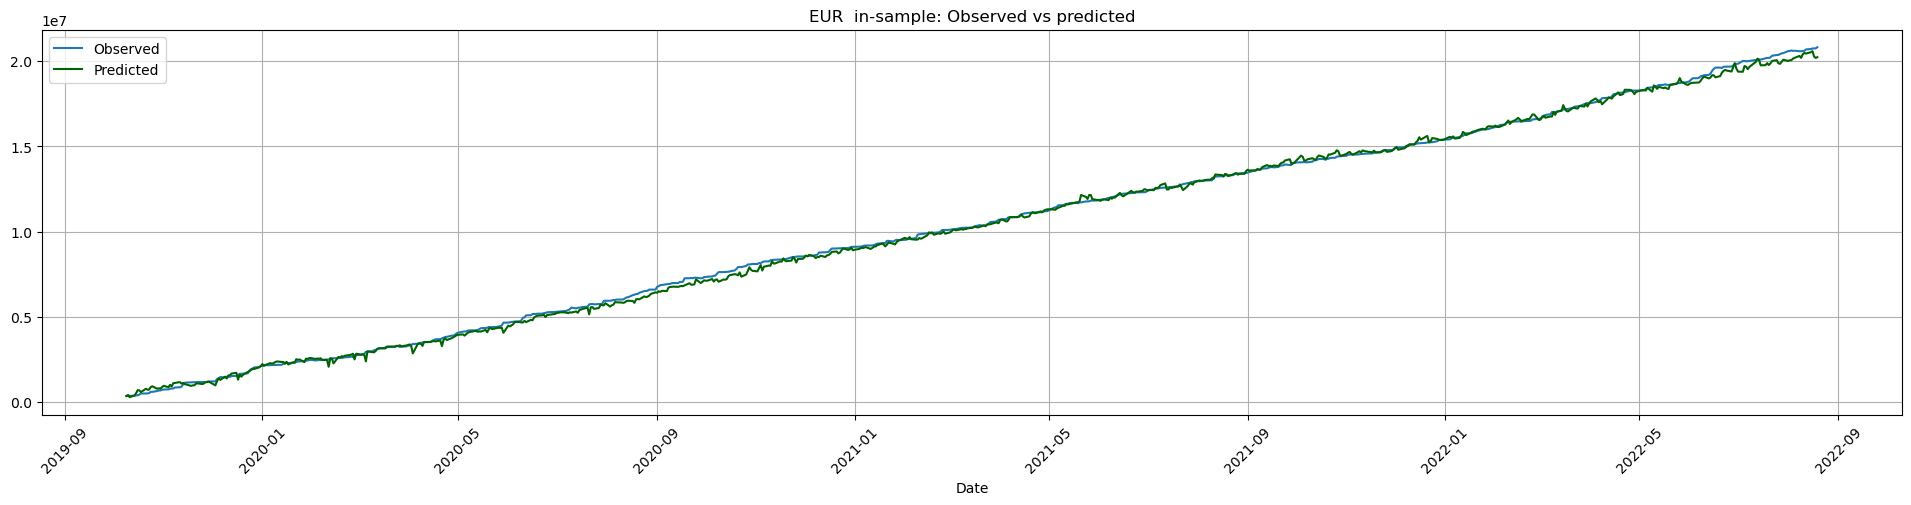

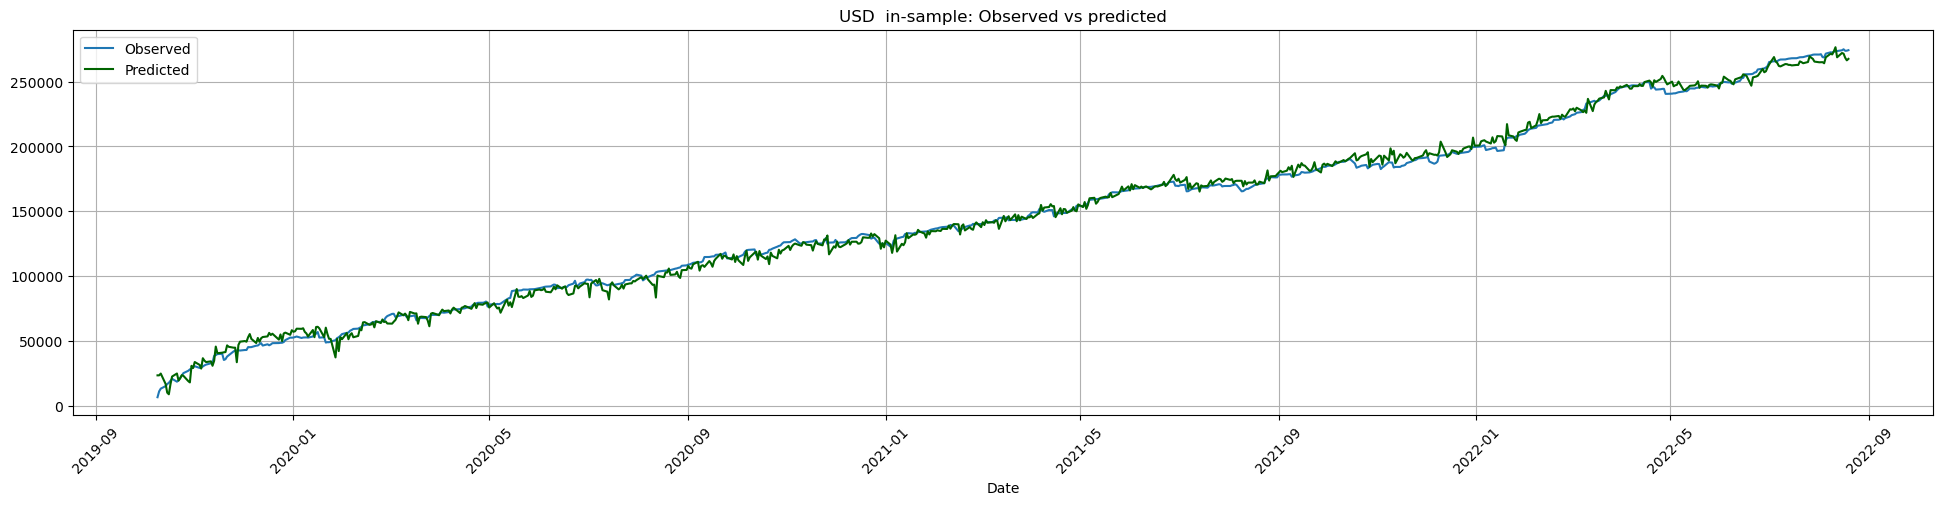

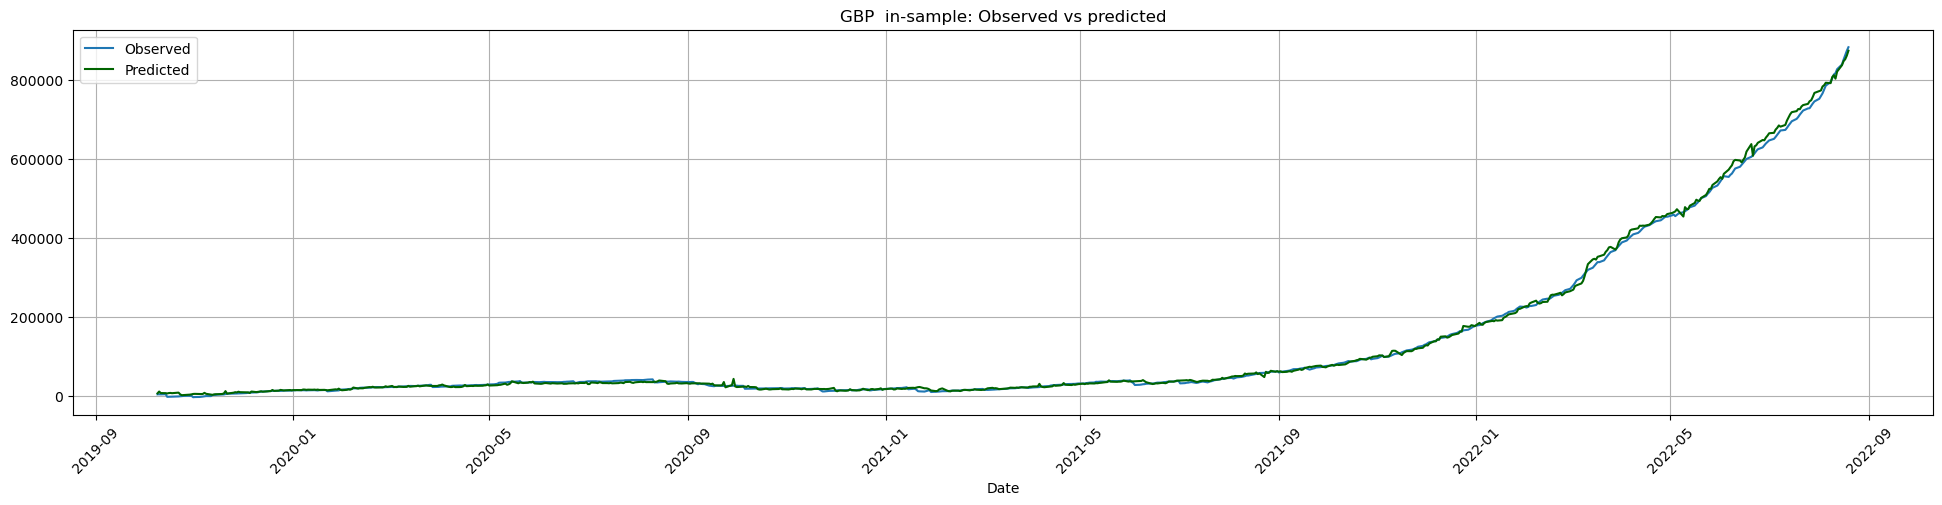

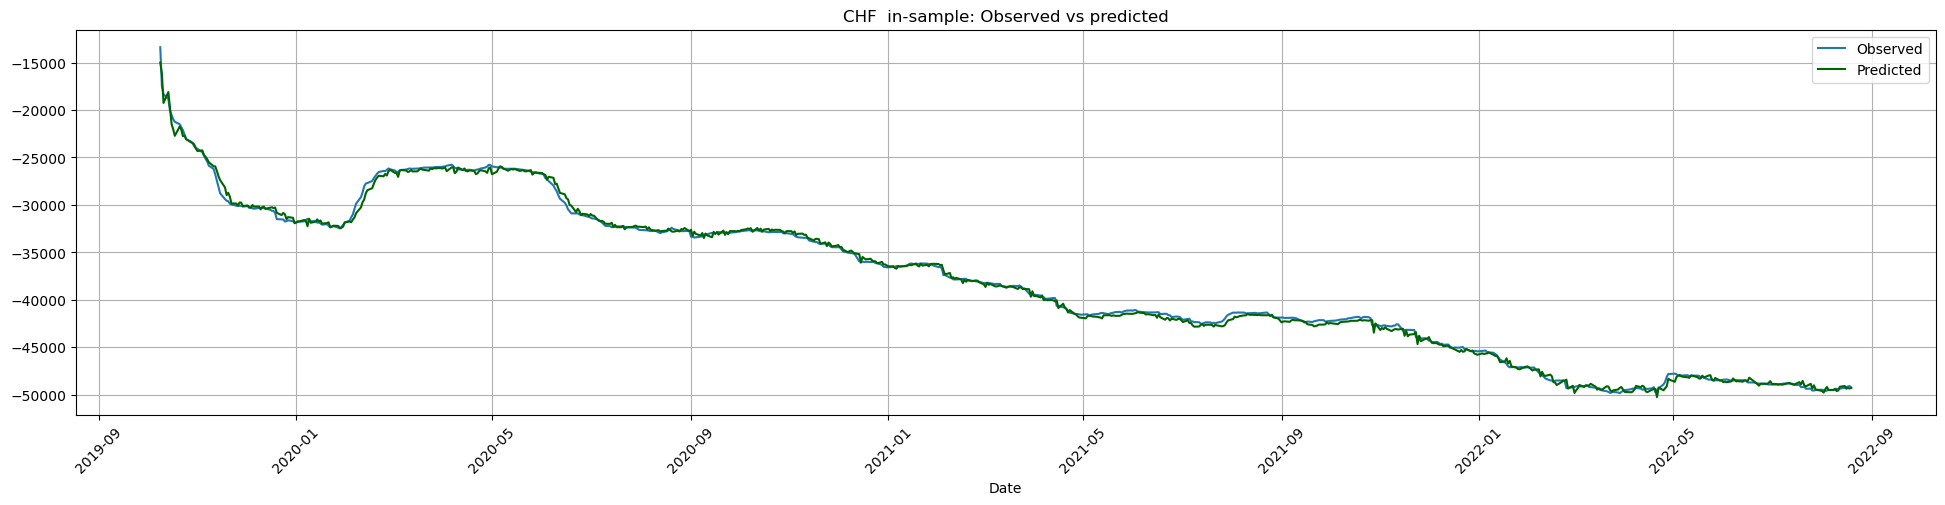

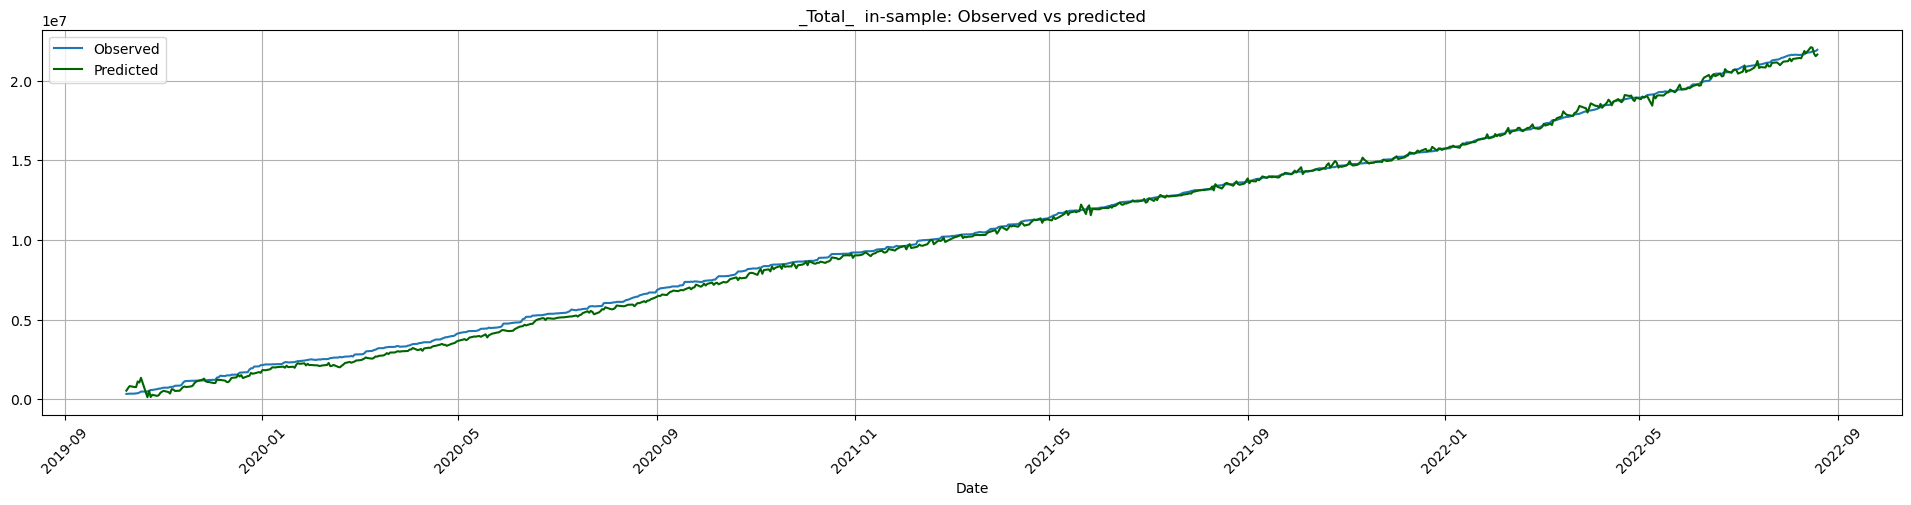

In [ ]:
# plot Actual vs Fitted
for c in currencies:
    plot_observed_vs_predicted(rnn_results[c]['y_train'], rnn_results[c]['trainPredict'], title1 = c+'  in-sample: Observed vs predicted')

In [ ]:
# Error Statistics
for c in currencies:
    res_stats_in_rnn[c] = error_statistics(rnn_results[c]['y_train'], rnn_results[c]['trainPredict'], df, colname=c)
res_stats_in_rnn    

EUR          USD          GBP  \
Root mean squared error          193,245.9      4,306.2      6,324.0   
Mean squared error        37,343,972,912.8 18,543,008.1 39,993,008.1   
Mean absolute error              146,308.6      3,312.8      4,337.4   
Median absolute error            112,562.1      2,679.0      2,699.1   
Mean absolute prctg error              0.0          0.0          0.2   
Explained variance                     1.0          1.0          1.0   
R2                                     NaN          NaN          NaN   
Correlation                            1.0          1.0          1.0   

                                CHF          _Total_  
Root mean squared error       351.0        260,135.0  
Mean squared error        123,178.7 67,670,222,000.7  
Mean absolute error           262.0        212,038.3  
Median absolute error         207.4        194,644.0  
Mean absolute prctg error       0.0              0.1  
Explained variance              1.0              1.0  
R2                              NaN              NaN  
Correlation                     1.0              1.0

#### Forecast: Out-of-sample

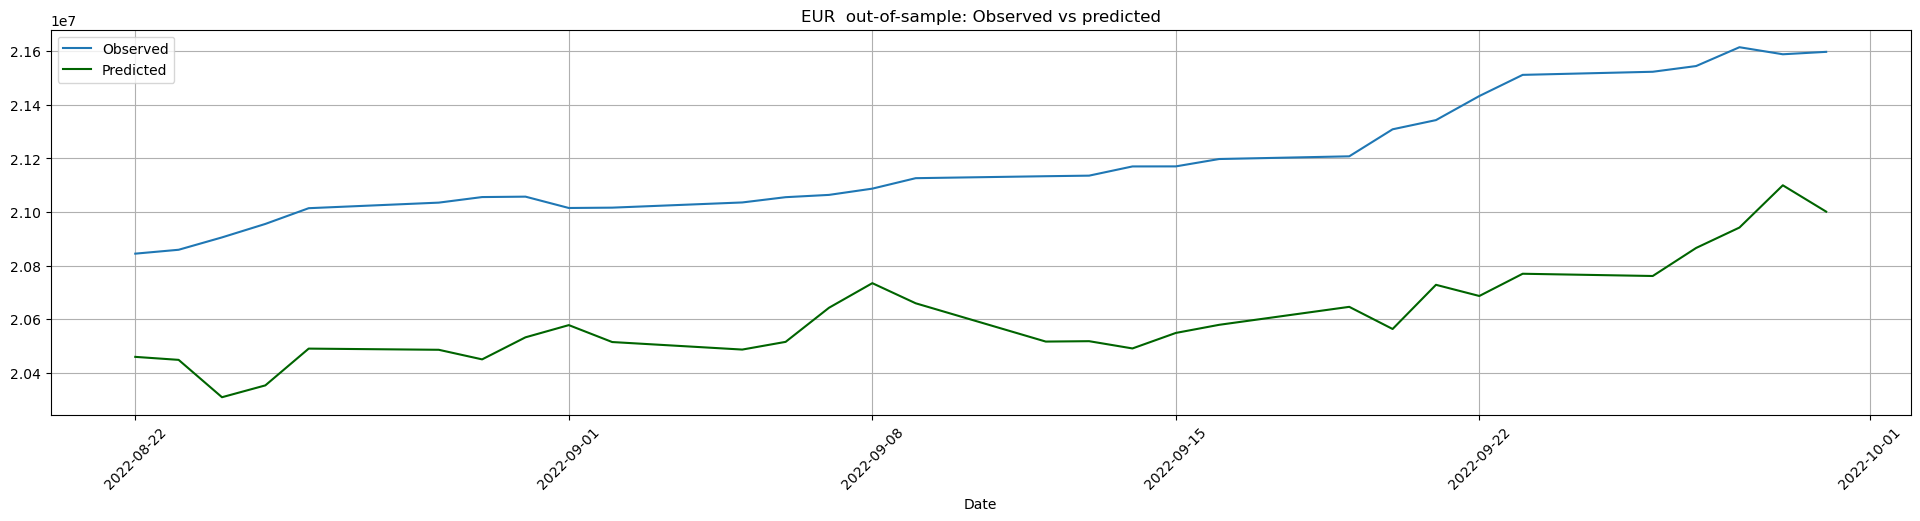

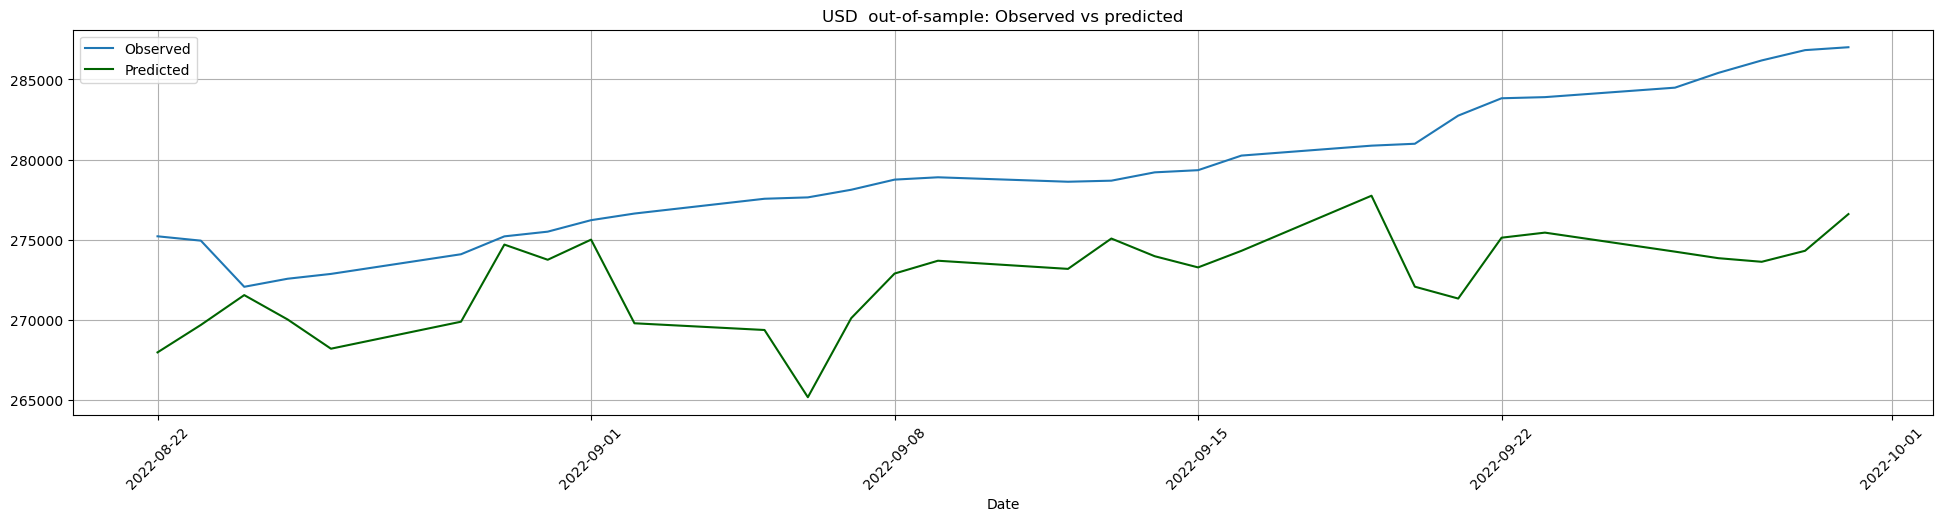

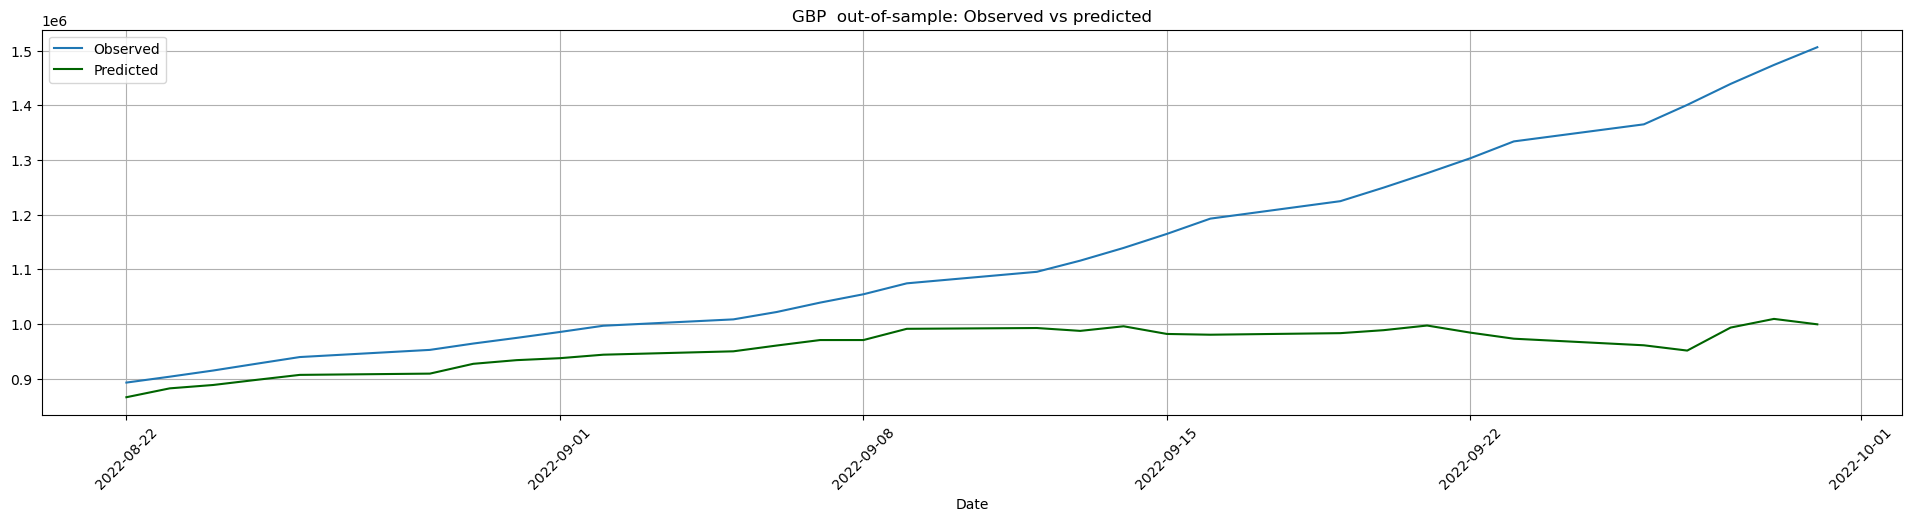

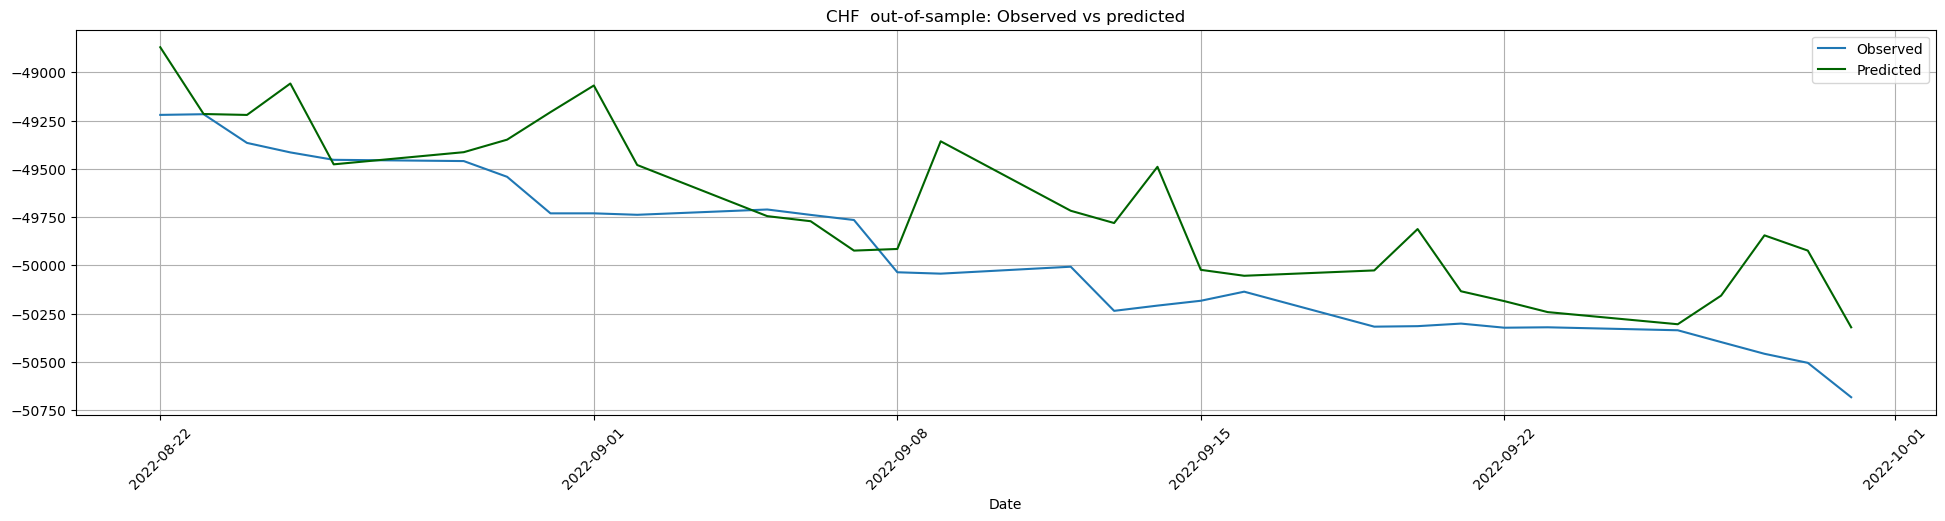

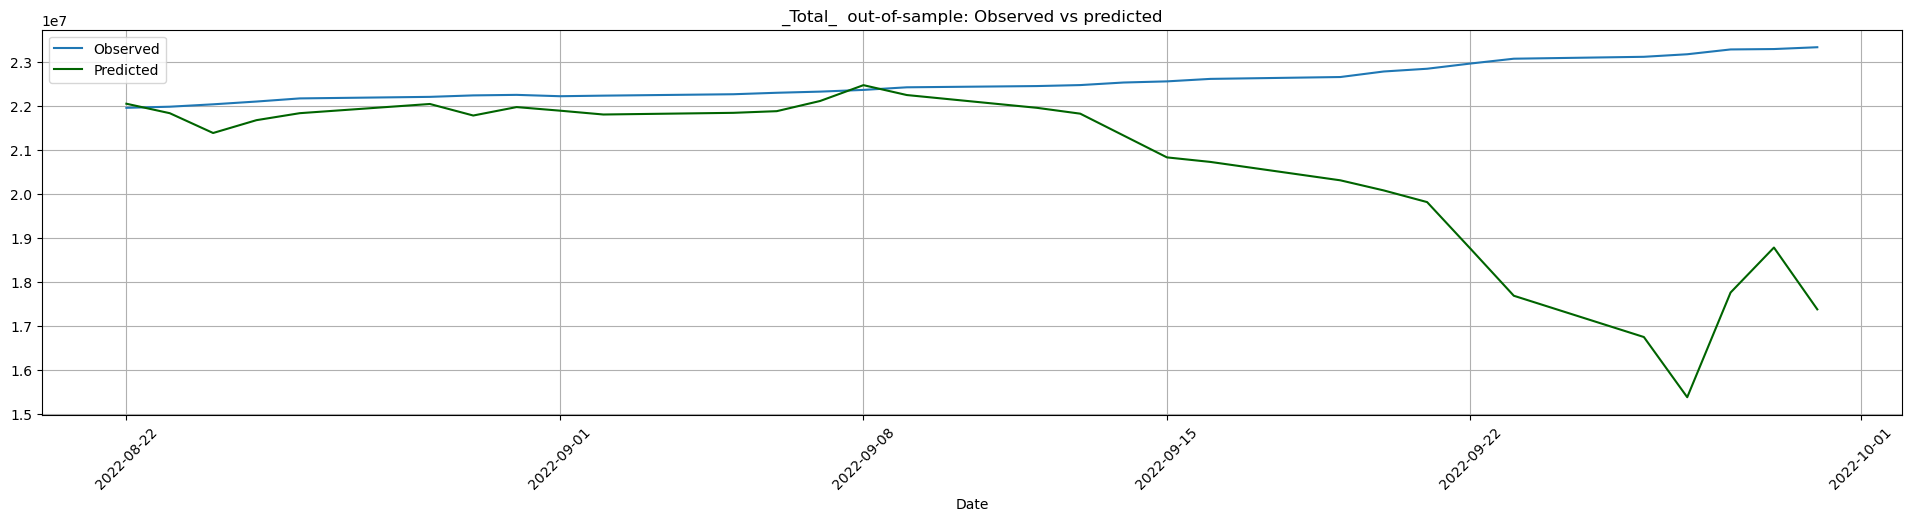

In [ ]:
for c in currencies:
    plot_observed_vs_predicted(rnn_results[c]['y_test'], rnn_results[c]['testPredict'], title1 = c+'  out-of-sample: Observed vs predicted')

In [ ]:
# Error Statistics
for c in currencies:
    res_stats_in_rnn[c] = error_statistics(rnn_results[c]['y_test'], rnn_results[c]['testPredict'], df, colname=c)
res_stats_in_rnn  


EUR          USD              GBP  \
Root mean squared error           584,056.6      7,516.0        233,718.3   
Mean squared error        341,122,151,913.3 56,490,813.9 54,624,239,256.7   
Mean absolute error               573,947.3      6,619.7        173,860.8   
Median absolute error             595,955.8      6,001.4         93,294.6   
Mean absolute prctg error               0.0          0.0              0.1   
Explained variance                      0.8          0.3              0.3   
R2                                      NaN          NaN              NaN   
Correlation                             0.9          0.6              0.7   

                                CHF             _Total_  
Root mean squared error       353.1         2,981,138.5  
Mean squared error        124,657.2 8,887,186,618,323.2  
Mean absolute error           276.9         1,947,044.7  
Median absolute error         216.6           571,798.2  
Mean absolute prctg error       0.0                 0.1  
Explained variance              0.7               -29.5  
R2                              NaN                 NaN  
Correlation                     0.8                -0.9

In [ ]:
# reset display settings
pd.reset_option('^display.', silent=True)